# Projet 7 : Implémentez un modèle de scoring

## Contexte:

Vous êtes Data Scientist au sein d'une société financière, nommée "Prêt à dépenser", qui propose des crédits à la consommation pour des personnes ayant peu ou pas du tout d'historique de prêt.

L’entreprise souhaite mettre en œuvre un outil de “scoring crédit” pour calculer la probabilité qu’un client rembourse son crédit, puis classifie la demande en crédit accordé ou refusé. Elle souhaite donc développer un algorithme de classification en s’appuyant sur des sources de données variées (données comportementales, données provenant d'autres institutions financières, etc.)

## Mission :

Construire un modèle de scoring qui donnera une prédiction sur la probabilité de faillite d'un client de façon automatique.

Analyser les features qui contribuent le plus au modèle, d’une manière générale (feature importance globale) et au niveau d’un client (feature importance locale), afin, dans un soucis de transparence, de permettre à un chargé d’études de mieux comprendre le score attribué par le modèle.

Mettre en production le modèle de scoring de prédiction à l’aide d’une API et réaliser une interface de test de cette API.

Mettre en œuvre une approche globale MLOps de bout en bout, du tracking des expérimentations à l’analyse en production du data drift.

## Analyse exploratoire des données

In [1]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# sklearn preprocessing for dealing with categorical variables
from sklearn.preprocessing import LabelEncoder

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns

import missingno as msno


In [53]:
# Training data
app_train = pd.read_csv('application_train.csv')
print('Training data shape: ', app_train.shape)
app_train.head()

Training data shape:  (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
# Liste des colonnes
list_col = list(app_train.columns)
print(list_col)

['SK_ID_CURR', 'TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE', 'FLAG_PHONE', 'FLAG_EMAIL', 'OCCUPATION_TYPE', 'CNT_FAM_MEMBERS', 'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'WEEKDAY_APPR_PROCESS_START', 'HOUR_APPR_PROCESS_START', 'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'LIVE_CITY_NOT_WORK_CITY', 'ORGANIZATION_TYPE', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELE

In [57]:
# Calcul du nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [59]:
# Copier les colonnes sélectionnées
app_analyse = app_train[['TARGET', 'NAME_CONTRACT_TYPE', 'CODE_GENDER', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY',
                         'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
                         'OCCUPATION_TYPE']].copy()

# Convertir les jours en positifs
app_analyse['DAYS_BIRTH'] = -app_analyse['DAYS_BIRTH']
app_analyse['DAYS_EMPLOYED'] = -app_analyse['DAYS_EMPLOYED']

# Calculer l'âge
app_analyse['AGE'] = np.round(app_analyse['DAYS_BIRTH'] / 365)

In [61]:
app_analyse.head(15)

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,DAYS_BIRTH,DAYS_EMPLOYED,OCCUPATION_TYPE,AGE
0,1,Cash loans,M,202500.000,406597.5,24700.5,Working,Secondary / secondary special,Single / not married,9461,637,Laborers,26.0
1,0,Cash loans,F,270000.000,1293502.5,35698.5,State servant,Higher education,Married,16765,1188,Core staff,46.0
2,0,Revolving loans,M,67500.000,135000.0,6750.0,Working,Secondary / secondary special,Single / not married,19046,225,Laborers,52.0
3,0,Cash loans,F,135000.000,312682.5,29686.5,Working,Secondary / secondary special,Civil marriage,19005,3039,Laborers,52.0
4,0,Cash loans,M,121500.000,513000.0,21865.5,Working,Secondary / secondary special,Single / not married,19932,3038,Core staff,55.0
5,0,Cash loans,M,99000.000,490495.5,27517.5,State servant,Secondary / secondary special,Married,16941,1588,Laborers,46.0
6,0,Cash loans,F,171000.000,1560726.0,41301.0,Commercial associate,Higher education,Married,13778,3130,Accountants,38.0
7,0,Cash loans,M,360000.000,1530000.0,42075.0,State servant,Higher education,Married,18850,449,Managers,52.0
8,0,Cash loans,F,112500.000,1019610.0,33826.5,Pensioner,Secondary / secondary special,Married,20099,-365243,NaN,55.0
9,0,Revolving loans,M,135000.000,405000.0,20250.0,Working,Secondary / secondary special,Single / not married,14469,2019,Laborers,40.0


In [63]:
# Sauvegarde de ce fichier à utiliser dans le dashboard
app_analyse.to_csv("df_analyse.csv")

### Analyse du Target

In [66]:
# Analyse du Target

app_train['TARGET'].value_counts()

TARGET
0    282686
1     24825
Name: count, dtype: int64

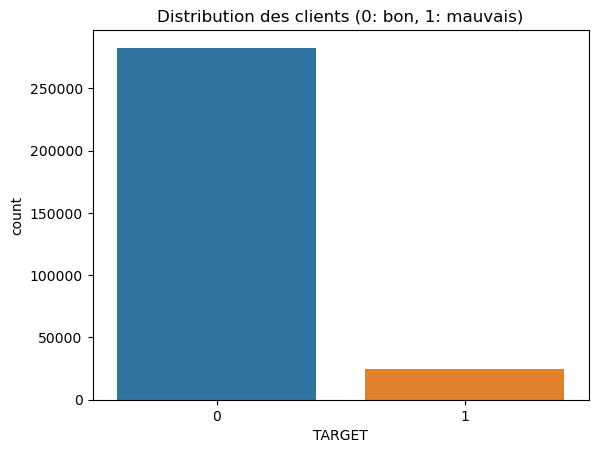

In [68]:
# Distribution de la variable cible
sns.countplot(x='TARGET', data=app_train)
plt.title("Distribution des clients (0: bon, 1: mauvais)")
plt.show()

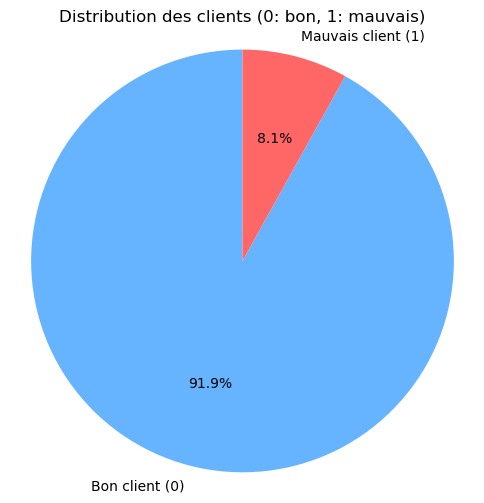

In [70]:
# Calcul des proportions de chaque classe
target_counts = app_train['TARGET'].value_counts()
target_labels = ['Bon client (0)', 'Mauvais client (1)']

# Création du camembert
plt.figure(figsize=(6, 6))
plt.pie(target_counts, labels=target_labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff6666'])
plt.title("Distribution des clients (0: bon, 1: mauvais)")
plt.axis('equal')  # Pour garder le cercle rond
plt.show()

### Analyse des valeurs manquantes

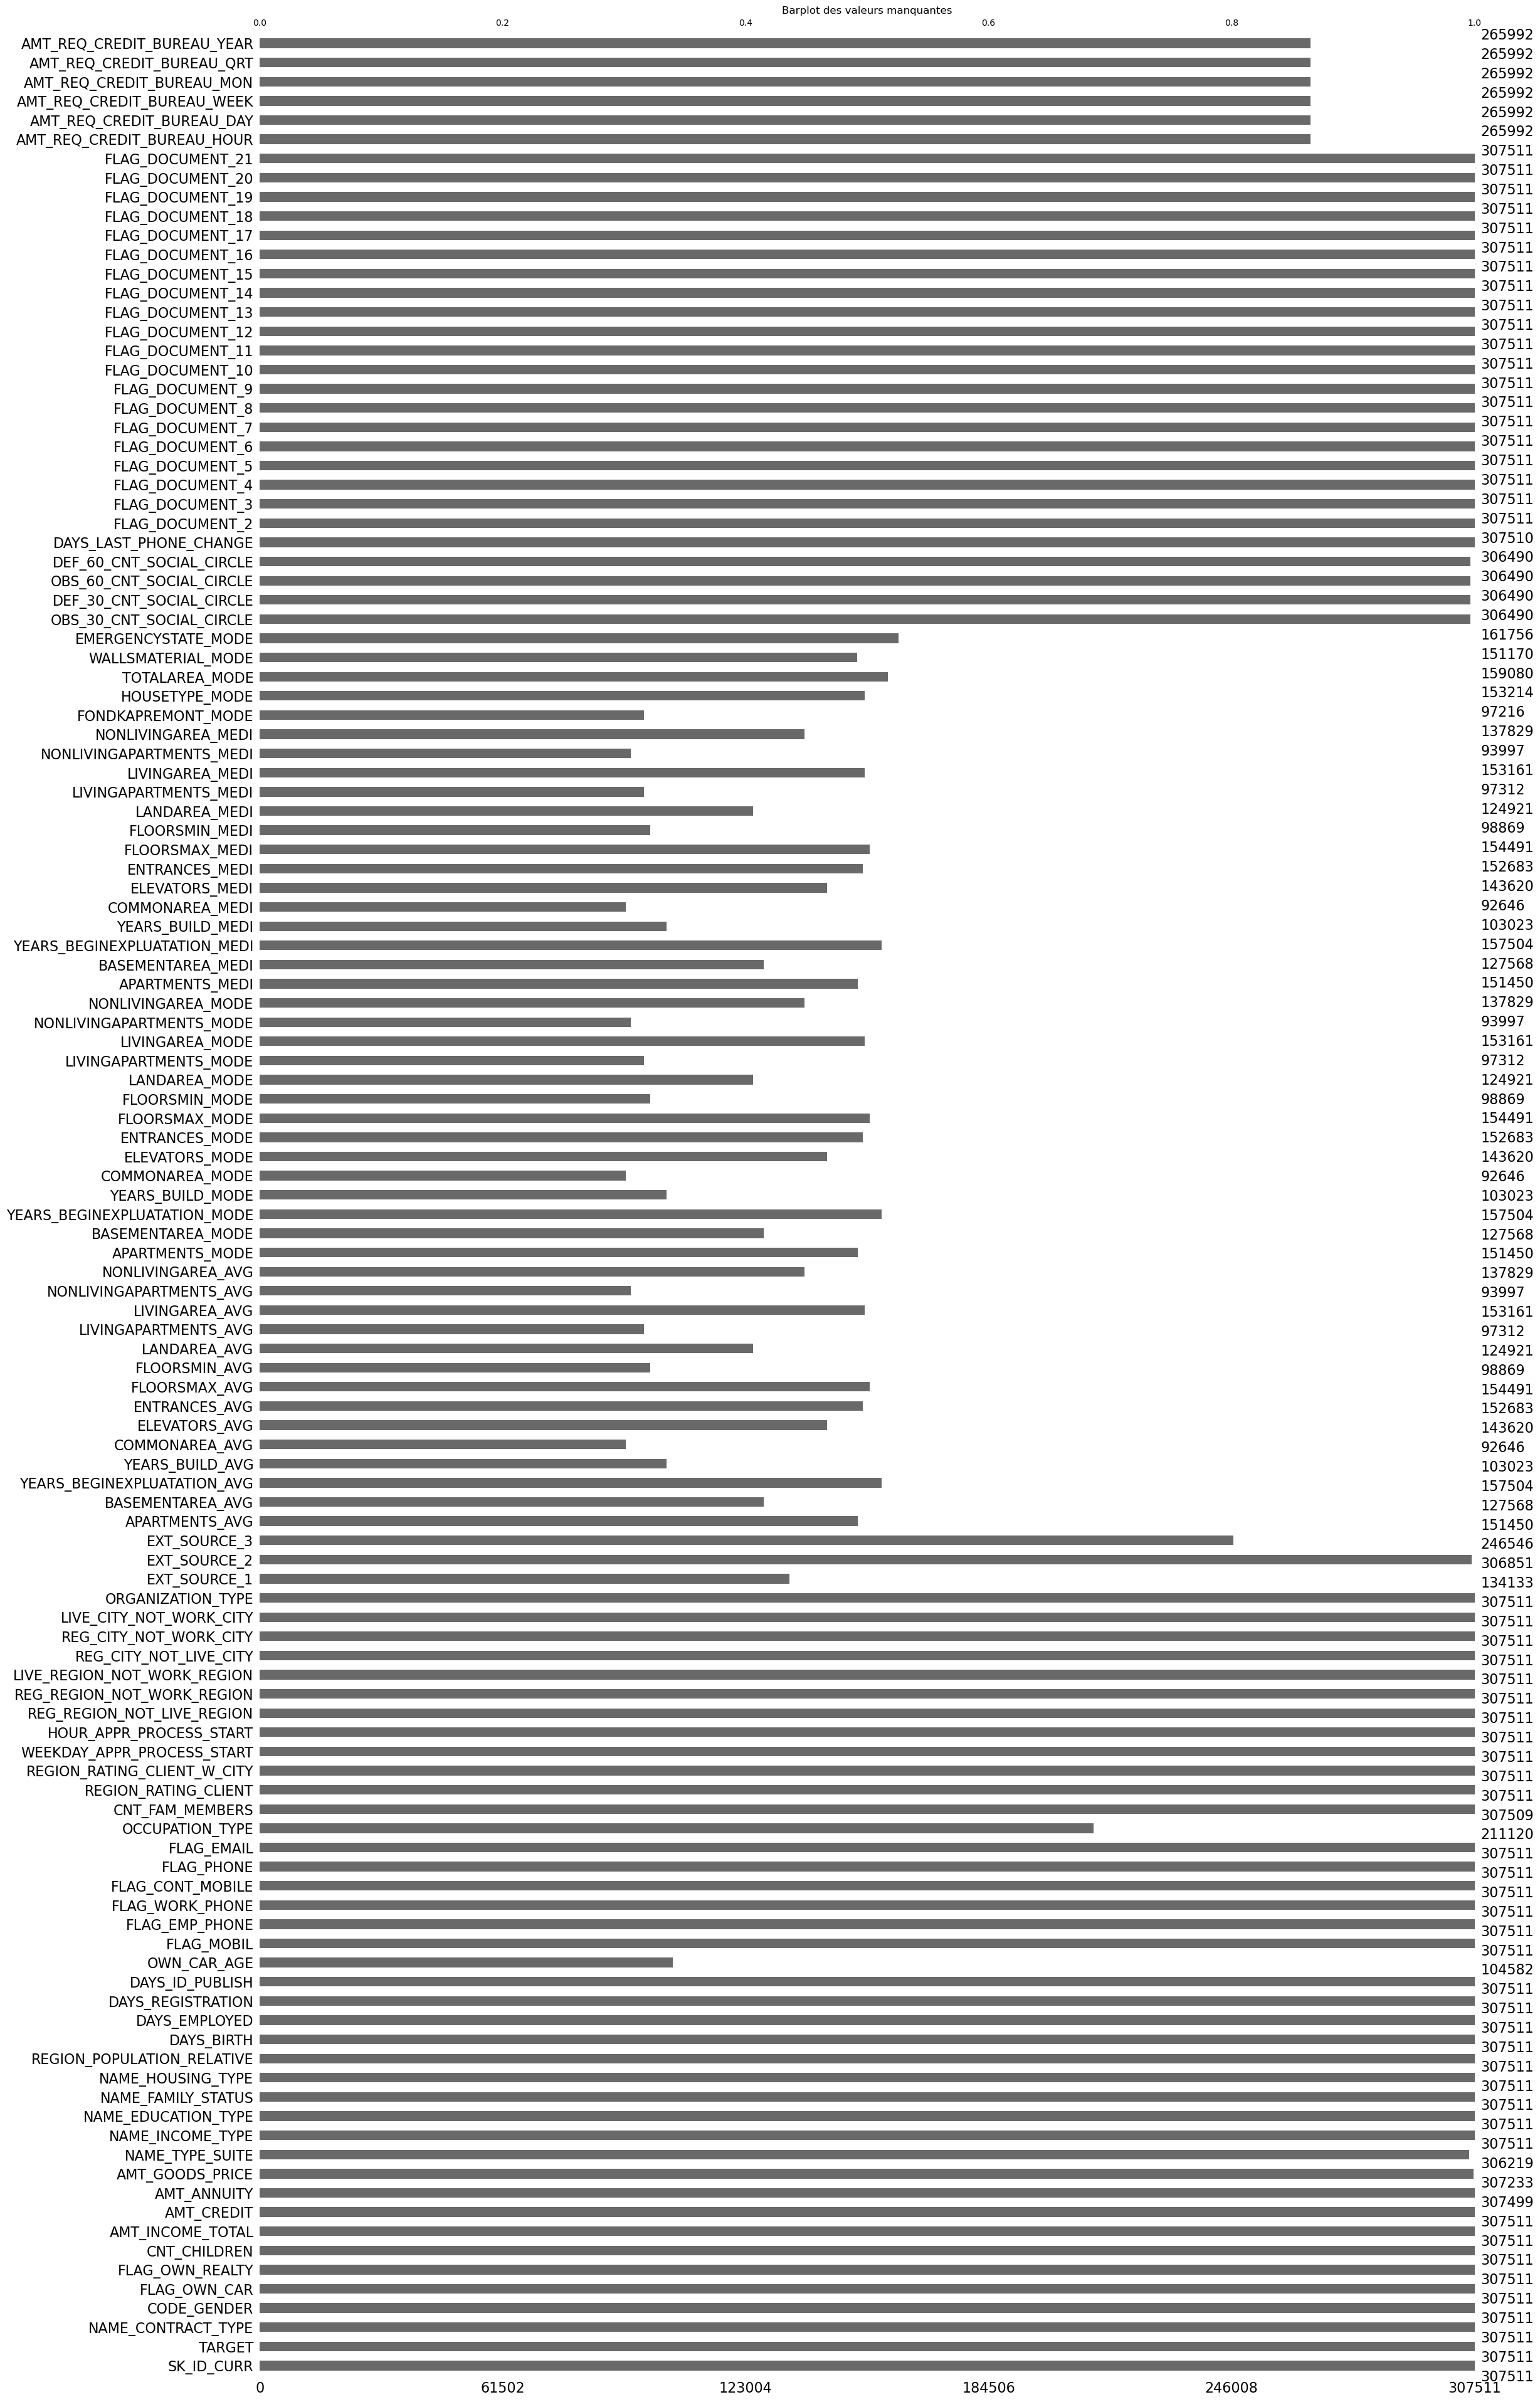

In [73]:

# Visualisation des valeurs manquantes sous forme de barplot
msno.bar(app_train)
plt.title('Barplot des valeurs manquantes')
plt.show()


In [74]:
# Function to calculate missing values by column# Funct 
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [77]:
# Missing values statistics
missing_values = missing_values_table(app_train)
missing_values.head(20)

Your selected dataframe has 122 columns.
There are 67 columns that have missing values.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [79]:
missing_values.head(30)

,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [81]:
missing_values.tail(37)

,Missing Values,% of Total Values
WALLSMATERIAL_MODE,156341,50.8
APARTMENTS_MODE,156061,50.7
APARTMENTS_MEDI,156061,50.7
APARTMENTS_AVG,156061,50.7
ENTRANCES_MODE,154828,50.3
ENTRANCES_AVG,154828,50.3
ENTRANCES_MEDI,154828,50.3
LIVINGAREA_MEDI,154350,50.2
LIVINGAREA_MODE,154350,50.2
LIVINGAREA_AVG,154350,50.2


### Analyse des features

In [86]:
# Calcul du nombre de chaque type de colonne
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
Name: count, dtype: int64

In [88]:
# Nombre de classes uniques dans chaque colonne d'objet
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Encodage avec Label Encoding et One Hot Encoding

In [91]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            app_train[col] = le.fit_transform(app_train[col])
            print('transformation colonne label encoding %s.' % col)            
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

transformation colonne label encoding NAME_CONTRACT_TYPE.
transformation colonne label encoding FLAG_OWN_CAR.
transformation colonne label encoding FLAG_OWN_REALTY.
3 columns were label encoded.


In [93]:
# one-hot encoding of categorical variables
print('Training Features shape avant : ', app_train.shape)

app_train = pd.get_dummies(app_train)

print('Training Features shape apres : ', app_train.shape)

Training Features shape avant :  (307511, 122)
Training Features shape apres :  (307511, 243)


In [95]:
# Number of each type of column
app_train.dtypes.value_counts()

bool       134
float64     65
int64       41
int32        3
Name: count, dtype: int64

### Suite d'AED

In [99]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

In [101]:
app_train['DAYS_EMPLOYED'].describe()

count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

In [103]:
app_train[app_train['DAYS_EMPLOYED']>0 ][['DAYS_EMPLOYED']]

,DAYS_EMPLOYED
8,365243
11,365243
23,365243
38,365243
43,365243
...,...
307469,365243
307483,365243
307487,365243
307505,365243


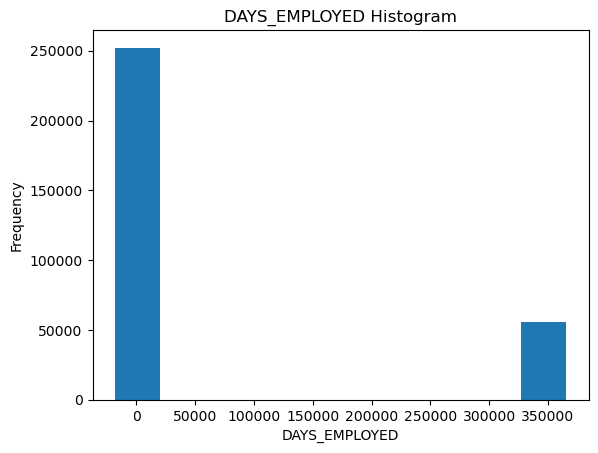

In [105]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram');
plt.xlabel('DAYS_EMPLOYED');

In [107]:
#singulatite pour 365243
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('Defaut paiement pour non anomalie pour %0.2f%% des prets' % (100 * non_anom['TARGET'].mean()))
print('Defaut paiement pour     anomalie pour %0.2f%% des prets' % (100 * anom['TARGET'].mean()))
print('Il y a %d anomalies dans DAYS_EMPLOYED' % len(anom))

Defaut paiement pour non anomalie pour 8.66% des prets
Defaut paiement pour     anomalie pour 5.40% des prets
Il y a 55374 anomalies dans DAYS_EMPLOYED


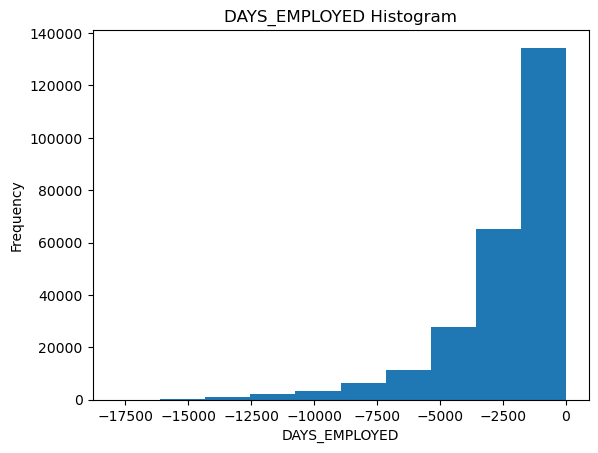

In [109]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = ( app_train["DAYS_EMPLOYED"] == 365243 )

# Replace the anomalous values with nan
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)

app_train['DAYS_EMPLOYED'].plot.hist(title = 'DAYS_EMPLOYED Histogram');
plt.xlabel('DAYS_EMPLOYED');

### Etude de corrélation

In [112]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

### DAYS_BIRTH

In [115]:
# Find the correlation of the positive days since birth and target
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982692

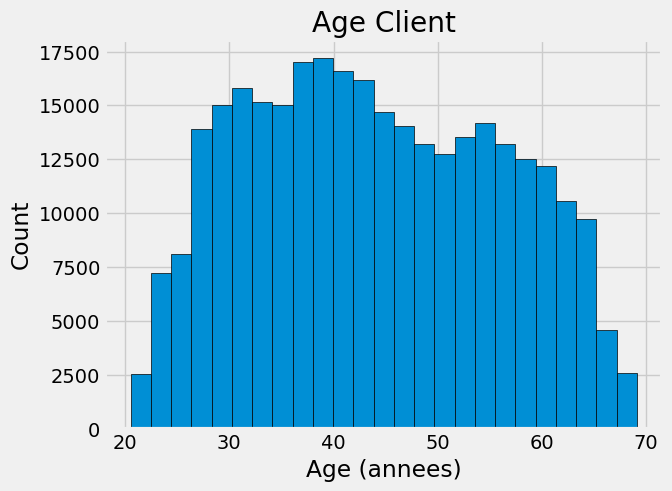

In [117]:
# Set the style of plots
plt.style.use('fivethirtyeight')

# Plot the distribution of ages in years
plt.hist(app_train['DAYS_BIRTH'] / 365, edgecolor = 'k', bins = 25)
plt.title('Age Client'); plt.xlabel('Age (annees)'); plt.ylabel('Count');

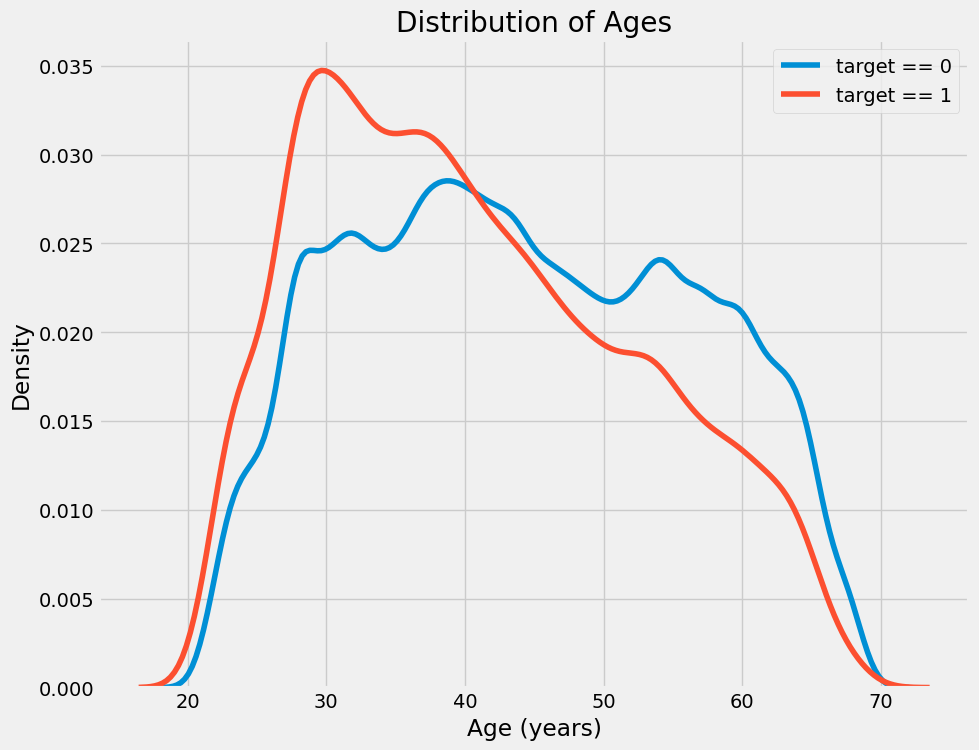

In [119]:
plt.figure(figsize = (10, 8))

# KDE plot of loans that were repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, 'DAYS_BIRTH'] / 365, label = 'target == 0')

# KDE plot of loans which were not repaid on time
sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, 'DAYS_BIRTH'] / 365, label = 'target == 1')

plt.legend()

# Labeling of plot
plt.xlabel('Age (years)'); plt.ylabel('Density'); plt.title('Distribution of Ages');

In [120]:
# Age information into a separate dataframe
age_data = app_train[['TARGET', 'DAYS_BIRTH']]
age_data['YEARS_BIRTH'] = age_data['DAYS_BIRTH'] / 365

# Bin the age data
age_data['YEARS_BINNED'] = pd.cut(age_data['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 11))
age_data.head(10)

,TARGET,DAYS_BIRTH,YEARS_BIRTH,YEARS_BINNED
0,1,9461,25.920548,"(25.0, 30.0]"
1,0,16765,45.931507,"(45.0, 50.0]"
2,0,19046,52.180822,"(50.0, 55.0]"
3,0,19005,52.068493,"(50.0, 55.0]"
4,0,19932,54.608219,"(50.0, 55.0]"
5,0,16941,46.413699,"(45.0, 50.0]"
6,0,13778,37.747945,"(35.0, 40.0]"
7,0,18850,51.643836,"(50.0, 55.0]"
8,0,20099,55.065753,"(55.0, 60.0]"
9,0,14469,39.641096,"(35.0, 40.0]"


In [123]:
# Group by the bin and calculate averages
age_groups  = age_data.groupby('YEARS_BINNED').mean()
age_groups

,TARGET,DAYS_BIRTH,YEARS_BIRTH
YEARS_BINNED,,,
"(20.0, 25.0]",0.123036,8532.795625,23.377522
"(25.0, 30.0]",0.111436,10155.219250,27.822518
"(30.0, 35.0]",0.102814,11854.848377,32.479037
"(35.0, 40.0]",0.089414,13707.908253,37.555913
"(40.0, 45.0]",0.078491,15497.661233,42.459346
"(45.0, 50.0]",0.074171,17323.900441,47.462741
"(50.0, 55.0]",0.066968,19196.494791,52.593136
"(55.0, 60.0]",0.055314,20984.262742,57.491131
"(60.0, 65.0]",0.052737,22780.547460,62.412459


Text(0.5, 1.0, "'Defaut Paiement par Groupe d'Age")

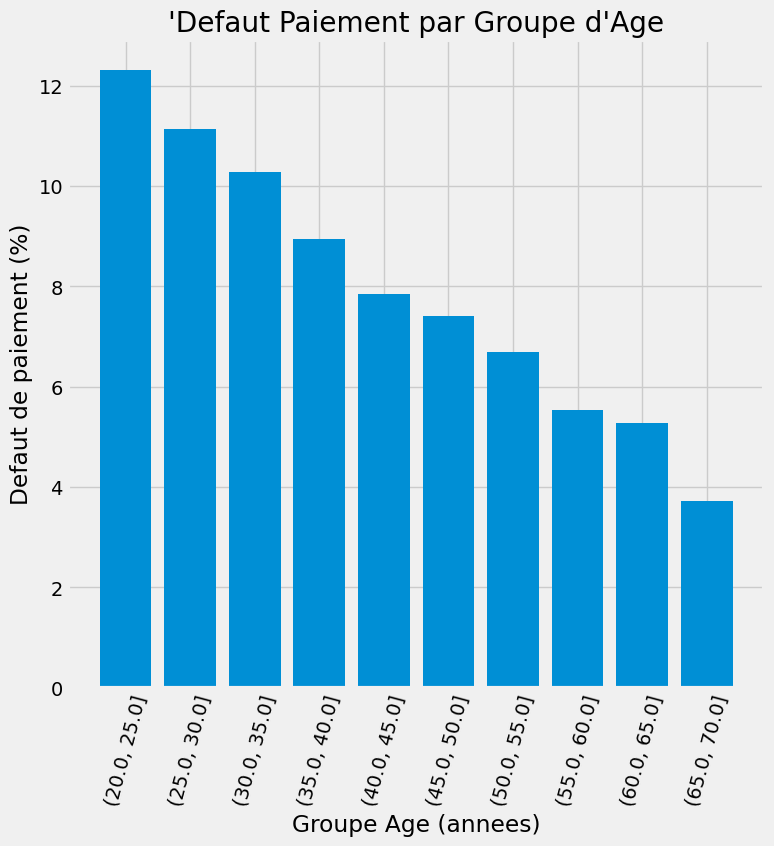

In [125]:
plt.figure(figsize = (8, 8))

# Graph the age bins and the average of the target as a bar plot
plt.bar(age_groups.index.astype(str), 100 * age_groups['TARGET'])

# Plot labeling
plt.xticks(rotation = 75); plt.xlabel('Groupe Age (annees)'); plt.ylabel('Defaut de paiement (%)')
plt.title("'Defaut Paiement par Groupe d'Age")

### EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3

In [128]:
# Extract the EXT_SOURCE variables and show correlations
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,-0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,0.205478
DAYS_BIRTH,-0.078239,0.600610,0.091996,0.205478,1.000000


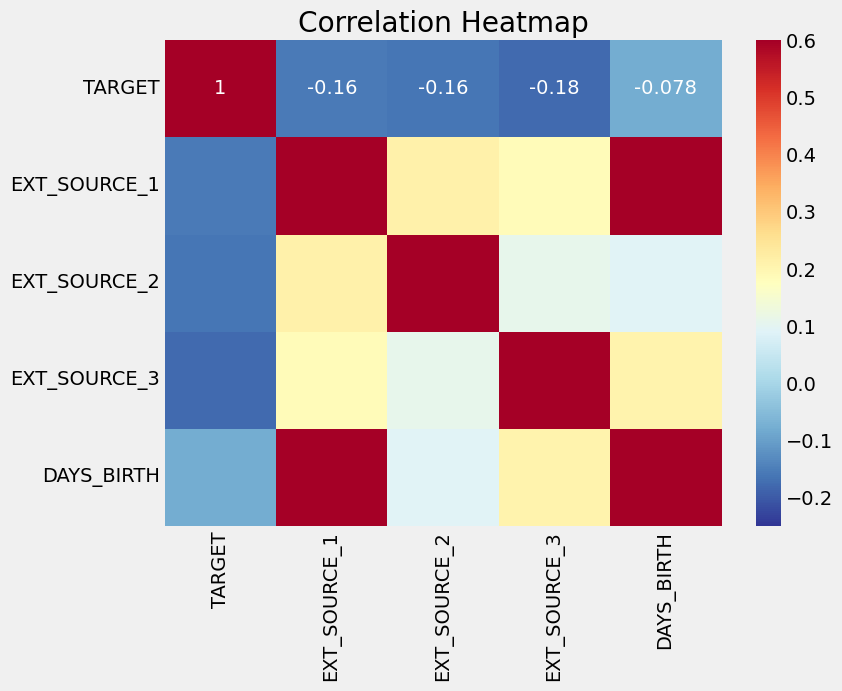

In [130]:
plt.figure(figsize = (8, 6))

# Heatmap of correlations
sns.heatmap(ext_data_corrs, cmap = plt.cm.RdYlBu_r, vmin = -0.25, annot = True, vmax = 0.6)
plt.title('Correlation Heatmap');

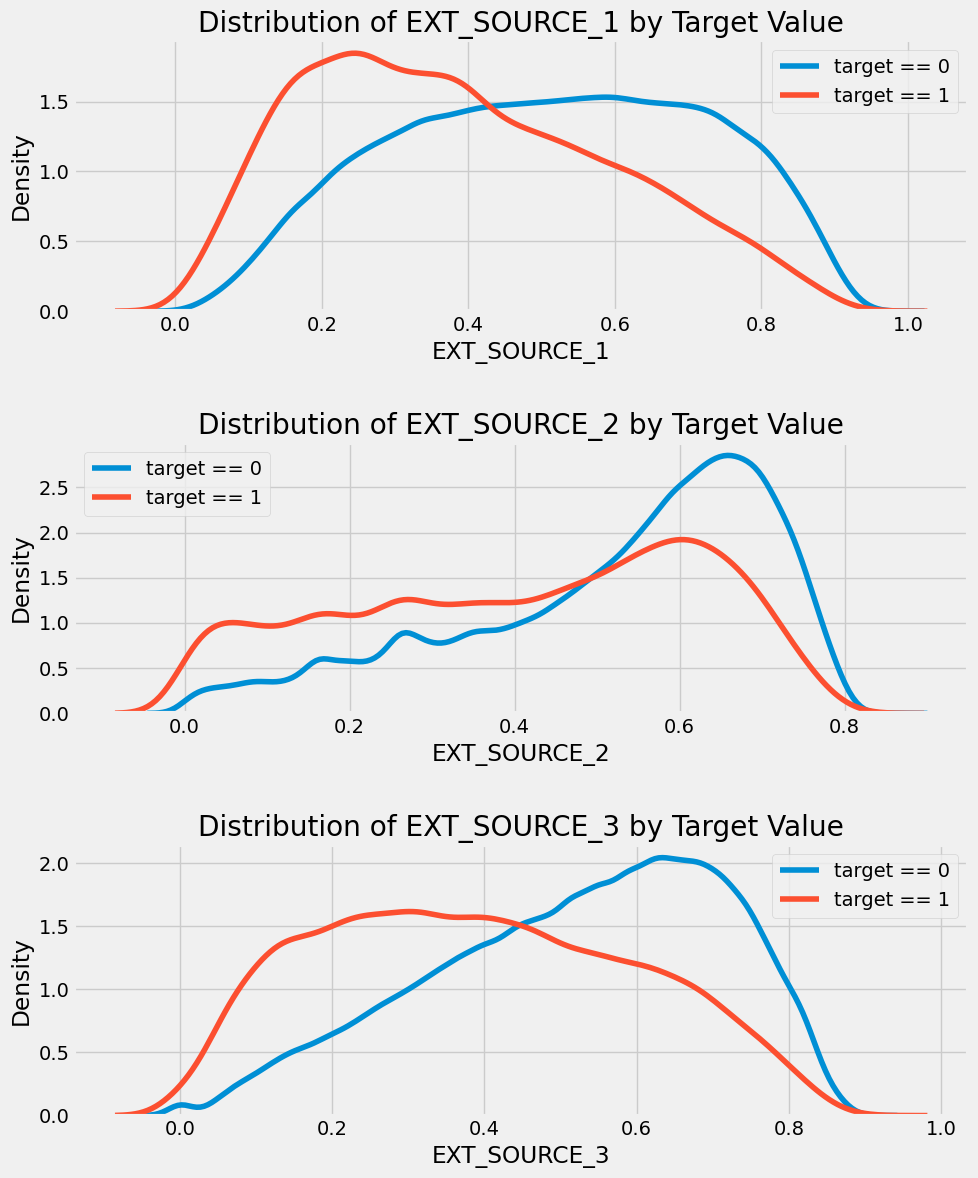

In [132]:
plt.figure(figsize = (10, 12))

# iterate through the sources
for i, source in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    
    # create a new subplot for each source
    plt.subplot(3, 1, i + 1)
    # plot repaid loans
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 0, source], label = 'target == 0')
    # plot loans that were not repaid
    sns.kdeplot(app_train.loc[app_train['TARGET'] == 1, source], label = 'target == 1')
    
    # Label the plots
    plt.title('Distribution of %s by Target Value' % source)
    plt.xlabel('%s' % source); plt.ylabel('Density');
    
    plt.legend()
    
plt.tight_layout(h_pad = 2.5)
    

### Domain Knowledge Features

Maybe it's not entirely correct to call this "domain knowledge" because I'm not a credit expert, but perhaps we could call this "attempts at applying limited financial knowledge". In this frame of mind, we can make a couple features that attempt to capture what we think may be important for telling whether a client will default on a loan. Here I'm going to use five features that were inspired by this script by Aguiar:

CREDIT_INCOME_PERCENT: the percentage of the credit amount relative to a client's income 
ANNUITY_INCOME_PERCENT: the percentage of the loan annuity relative to a client's income 
CREDIT_TERM: the length of the payment in months (since the annuity is the monthly amount due 
DAYS_EMPLOYED_PERCENT: the percentage of the days employed relative to the client's age 

Again, thanks to Aguiar and his great script for exploring these features.

In [134]:
app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

## Dataset complet et feature engineering

In [3]:
# Chargement des librairies
import gc
import re
import time
from contextlib import contextmanager
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print("{} - done in {:.0f}s".format(title, time.time() - t0))

In [7]:
# run functions and pre_settings
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

def group(df_to_agg, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = df_to_agg.groupby(aggregate_by).agg(aggregations)
    agg_df.columns = pd.Index(['{}{}_{}'.format(prefix, e[0], e[1].upper())
                               for e in agg_df.columns.tolist()])
    return agg_df.reset_index()

def group_and_merge(df_to_agg, df_to_merge, prefix, aggregations, aggregate_by= 'SK_ID_CURR'):
    agg_df = group(df_to_agg, prefix, aggregations, aggregate_by= aggregate_by)
    return df_to_merge.merge(agg_df, how='left', on= aggregate_by)

def do_sum(dataframe, group_cols, counted, agg_name):
    gp = dataframe[group_cols + [counted]].groupby(group_cols)[counted].sum().reset_index().rename(columns={counted: agg_name})
    dataframe = dataframe.merge(gp, on=group_cols, how='left')
    return dataframe

def reduce_mem_usage(dataframe):
    m_start = dataframe.memory_usage().sum() / 1024 ** 2
    for col in dataframe.columns:
        col_type = dataframe[col].dtype
        if col_type != object:
            c_min = dataframe[col].min()
            c_max = dataframe[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    dataframe[col] = dataframe[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    dataframe[col] = dataframe[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    dataframe[col] = dataframe[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    dataframe[col] = dataframe[col].astype(np.int64)
            elif str(col_type)[:5] == 'float':
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    dataframe[col] = dataframe[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    dataframe[col] = dataframe[col].astype(np.float32)
                else:
                    dataframe[col] = dataframe[col].astype(np.float64)

    m_end = dataframe.memory_usage().sum() / 1024 ** 2
    return dataframe

nan_as_category = True

In [9]:
import numpy as np
import pandas as pd
import warnings  # Importing the warnings module

def application():
    df = pd.read_csv(r'application_train.csv')

    # General cleaning procedures
    df = df[df['CODE_GENDER'] != 'XNA']
    df = df[df['AMT_INCOME_TOTAL'] < 20000000]  # Remove a large outlier (117M)
    
    # NaN values for DAYS_EMPLOYED and DAYS_LAST_PHONE_CHANGE
    df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)
    df['DAYS_LAST_PHONE_CHANGE'].replace(0, np.nan, inplace=True)

    # Binary encoding for categorical features with two categories
    for bin_feature in ['CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
        df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    # One-Hot encoding for categorical features
    df, cat_cols = one_hot_encoder(df, nan_as_category=True)

    # Create new features based on document flags
    docs = [f for f in df.columns if 'FLAG_DOC' in f]
    df['DOCUMENT_COUNT'] = df[docs].sum(axis=1)
    df['NEW_DOC_KURT'] = df[docs].kurtosis(axis=1)

    # Function to categorize age
    def get_age_label(days_birth):
        age_years = -days_birth / 365
        if age_years < 27:
            return 1
        elif age_years < 40:
            return 2
        elif age_years < 50:
            return 3
        elif age_years < 65:
            return 4
        elif age_years < 99:
            return 5
        else:
            return 0
    
    # Apply age categories
    df['AGE_RANGE'] = df['DAYS_BIRTH'].apply(lambda x: get_age_label(x))

    # Create new features based on external sources
    df['EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']
    df['EXT_SOURCES_WEIGHTED'] = df['EXT_SOURCE_1'] * 2 + df['EXT_SOURCE_2'] * 1 + df['EXT_SOURCE_3'] * 3

    # Suppress warnings related to all-NaN slices
    warnings.filterwarnings('ignore', category=RuntimeWarning, message='All-NaN (slice|axis) encountered')

    # Add statistical features for EXT_SOURCE columns
    for function_name in ['min', 'max', 'mean', 'nanmedian', 'var']:
        feature_name = f'EXT_SOURCES_{function_name.upper()}'
        df[feature_name] = getattr(np, function_name)(
            df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']], axis=1)

    # Create additional ratio-based features
    df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
    df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
    df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
    df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

    # Credit and income ratios
    df['CREDIT_TO_GOODS_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']
    df['INCOME_TO_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']
    df['INCOME_TO_BIRTH_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_BIRTH']

    # Time ratios
    df['ID_TO_BIRTH_RATIO'] = df['DAYS_ID_PUBLISH'] / df['DAYS_BIRTH']
    df['CAR_TO_BIRTH_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_BIRTH']
    df['CAR_TO_EMPLOYED_RATIO'] = df['OWN_CAR_AGE'] / df['DAYS_EMPLOYED']
    df['PHONE_TO_BIRTH_RATIO'] = df['DAYS_LAST_PHONE_CHANGE'] / df['DAYS_BIRTH']

    # More features based on EXT_SOURCE ratios
    df['APPS_EXT_SOURCE_MEAN'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
    df['APPS_EXT_SOURCE_STD'] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1).fillna(df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].std(axis=1).mean())

    # Additional ratio features for EXT_SOURCE
    df['APP_SCORE1_TO_BIRTH_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE2_TO_BIRTH_RATIO'] = df['EXT_SOURCE_2'] / (df['DAYS_BIRTH'] / 365.25)
    df['APP_SCORE3_TO_BIRTH_RATIO'] = df['EXT_SOURCE_3'] / (df['DAYS_BIRTH'] / 365.25)

    # More combinations of features
    df['APP_SCORE1_TO_EMPLOY_RATIO'] = df['EXT_SOURCE_1'] / (df['DAYS_EMPLOYED'] / 365.25)
    df['APP_EXT_SOURCE_1*EXT_SOURCE_2*DAYS_BIRTH'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['DAYS_BIRTH']
    df['APP_SCORE1_TO_FAM_CNT_RATIO'] = df['EXT_SOURCE_1'] / df['CNT_FAM_MEMBERS']

    # Add other ratios and interactions
    df['APP_SCORE1_TO_GOODS_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_GOODS_PRICE']
    df['APP_SCORE1_TO_CREDIT_RATIO'] = df['EXT_SOURCE_1'] / df['AMT_CREDIT']
    df['APP_SCORE1_TO_SCORE2_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_2']
    df['APP_SCORE1_TO_SCORE3_RATIO'] = df['EXT_SOURCE_1'] / df['EXT_SOURCE_3']
    df['APP_SCORE2_TO_CREDIT_RATIO'] = df['EXT_SOURCE_2'] / df['AMT_CREDIT']
    df['APP_SCORE2_TO_REGION_RATING_RATIO'] = df['EXT_SOURCE_2'] / df['REGION_RATING_CLIENT']

    # Add final ratio features
    df['APPS_GOODS_INCOME_RATIO'] = df['AMT_GOODS_PRICE'] / df['AMT_INCOME_TOTAL']
    df['APPS_CNT_FAM_INCOME_RATIO'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
    df['APPS_INCOME_EMPLOYED_RATIO'] = df['AMT_INCOME_TOTAL'] / df['DAYS_EMPLOYED']

    print('"Application_Train_Test" final shape:', df.shape)
    return df


In [11]:
df = application()  # Exécute la fonction et stocke le résultat dans df
df  # Affiche df

"Application_Train_Test" final shape: (307506, 294)


,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,APP_SCORE1_TO_FAM_CNT_RATIO,APP_SCORE1_TO_GOODS_RATIO,APP_SCORE1_TO_CREDIT_RATIO,APP_SCORE1_TO_SCORE2_RATIO,APP_SCORE1_TO_SCORE3_RATIO,APP_SCORE2_TO_CREDIT_RATIO,APP_SCORE2_TO_REGION_RATING_RATIO,APPS_GOODS_INCOME_RATIO,APPS_CNT_FAM_INCOME_RATIO,APPS_INCOME_EMPLOYED_RATIO
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,0.083037,2.365726e-07,2.042240e-07,0.315792,0.595778,6.467049e-07,0.131474,1.733333,202500.0,-317.896389
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,0.155634,2.755797e-07,2.406391e-07,0.500232,NaN,4.810549e-07,0.622246,4.183333,135000.0,-227.272727
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,4.117867e-06,0.277956,2.000000,67500.0,-300.000000
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,NaN,NaN,NaN,NaN,NaN,2.080199e-06,0.325221,2.200000,67500.0,-44.422507
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,6.291195e-07,0.161369,4.222222,121500.0,-39.993417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,0.145570,6.469798e-07,5.715369e-07,0.213562,NaN,2.676217e-06,0.681632,1.428571,157500.0,-667.372881
307507,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,4.303175e-07,0.057996,3.125000,72000.0,NaN
307508,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,0.744026,1.271840e-06,1.097928e-06,1.388830,3.399568,7.905418e-07,0.178574,3.823529,153000.0,-19.315743
307509,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,1.389227e-06,0.257081,1.868421,85500.0,-35.729210


In [12]:
def bureau_bb():
    bureau = pd.read_csv(r'bureau.csv')
    bb = pd.read_csv(r'bureau_balance.csv')

    # Credit duration and credit/account end date difference
    bureau['CREDIT_DURATION'] = -bureau['DAYS_CREDIT'] + bureau['DAYS_CREDIT_ENDDATE']
    bureau['ENDDATE_DIF'] = bureau['DAYS_CREDIT_ENDDATE'] - bureau['DAYS_ENDDATE_FACT']
    
    # Credit to debt ratio and difference
    bureau['DEBT_PERCENTAGE'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_CREDIT_SUM_DEBT']
    bureau['DEBT_CREDIT_DIFF'] = bureau['AMT_CREDIT_SUM'] - bureau['AMT_CREDIT_SUM_DEBT']
    bureau['CREDIT_TO_ANNUITY_RATIO'] = bureau['AMT_CREDIT_SUM'] / bureau['AMT_ANNUITY']
    bureau['BUREAU_CREDIT_FACT_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_ENDDATE_FACT']
    bureau['BUREAU_CREDIT_ENDDATE_DIFF'] = bureau['DAYS_CREDIT'] - bureau['DAYS_CREDIT_ENDDATE']
    bureau['BUREAU_CREDIT_DEBT_RATIO'] = bureau['AMT_CREDIT_SUM_DEBT'] / bureau['AMT_CREDIT_SUM']

    # CREDIT_DAY_OVERDUE :
    bureau['BUREAU_IS_DPD'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 0 else 0)
    bureau['BUREAU_IS_DPD_OVER120'] = bureau['CREDIT_DAY_OVERDUE'].apply(lambda x: 1 if x > 120 else 0)

    bb, bb_cat = one_hot_encoder(bb, nan_as_category)
    bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category)

    # Bureau balance: Perform aggregations and merge with bureau.csv
    bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size', 'mean']}
    for col in bb_cat:
        bb_aggregations[col] = ['mean']

    #Status of Credit Bureau loan during the month
    bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
    bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])
    bureau = bureau.join(bb_agg, how='left', on='SK_ID_BUREAU')

    # Bureau and bureau_balance numeric features
    num_aggregations = {
        'DAYS_CREDIT': ['min', 'max', 'mean', 'var'],
        'DAYS_CREDIT_ENDDATE': ['min', 'max', 'mean'],
        'DAYS_CREDIT_UPDATE': ['mean'],
        'CREDIT_DAY_OVERDUE': ['max', 'mean', 'min'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean', 'max'],
        'AMT_CREDIT_SUM': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_DEBT': ['max', 'mean', 'sum'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean', 'max', 'sum'],
        'AMT_CREDIT_SUM_LIMIT': ['mean', 'sum'],
        'AMT_ANNUITY': ['max', 'mean', 'sum'],
        'CNT_CREDIT_PROLONG': ['sum'],
        'MONTHS_BALANCE_MIN': ['min'],
        'MONTHS_BALANCE_MAX': ['max'],
        'MONTHS_BALANCE_SIZE': ['mean', 'sum'],
        'SK_ID_BUREAU': ['count'],
        'DAYS_ENDDATE_FACT': ['min', 'max', 'mean'],
        'ENDDATE_DIF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_FACT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_ENDDATE_DIFF': ['min', 'max', 'mean'],
        'BUREAU_CREDIT_DEBT_RATIO': ['min', 'max', 'mean'],
        'DEBT_CREDIT_DIFF': ['min', 'max', 'mean'],
        'BUREAU_IS_DPD': ['mean', 'sum'],
        'BUREAU_IS_DPD_OVER120': ['mean', 'sum']
        }

    # Bureau and bureau_balance categorical features
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    for cat in bb_cat: cat_aggregations[cat + "_MEAN"] = ['mean']
    bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])

    # Bureau: Active credits - using only numerical aggregations
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on='SK_ID_CURR')

    # Bureau: Closed credits - using only numerical aggregations
    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on='SK_ID_CURR')

    print('"Bureau/Bureau Balance" final shape:', bureau_agg.shape)
    return bureau_agg

In [15]:
def previous_application():
    prev = pd.read_csv(r'previous_application.csv')

    prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

    # Days 365.243 values -> nan
    prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
    prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
    prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
    prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

    # Add feature: value ask / value received percentage
    prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

    # Feature engineering: ratios and difference
    prev['APPLICATION_CREDIT_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_CREDIT']
    prev['CREDIT_TO_ANNUITY_RATIO'] = prev['AMT_CREDIT'] / prev['AMT_ANNUITY']
    prev['DOWN_PAYMENT_TO_CREDIT'] = prev['AMT_DOWN_PAYMENT'] / prev['AMT_CREDIT']

    # Interest ratio on previous application (simplified)
    total_payment = prev['AMT_ANNUITY'] * prev['CNT_PAYMENT']
    prev['SIMPLE_INTERESTS'] = (total_payment / prev['AMT_CREDIT'] - 1) / prev['CNT_PAYMENT']

    # Days last due difference (scheduled x done)
    prev['DAYS_LAST_DUE_DIFF'] = prev['DAYS_LAST_DUE_1ST_VERSION'] - prev['DAYS_LAST_DUE']

    # from off
    prev['PREV_GOODS_DIFF'] = prev['AMT_APPLICATION'] - prev['AMT_GOODS_PRICE']
    prev['PREV_ANNUITY_APPL_RATIO'] = prev['AMT_ANNUITY']/prev['AMT_APPLICATION']
    prev['PREV_GOODS_APPL_RATIO'] = prev['AMT_GOODS_PRICE'] / prev['AMT_APPLICATION']

    # Previous applications numeric features
    num_aggregations = {
        'AMT_ANNUITY': ['min', 'max', 'mean', 'sum'],
        'AMT_APPLICATION': ['min', 'max', 'mean', 'sum'],
        'AMT_CREDIT': ['min', 'max', 'mean', 'sum'],
        'APP_CREDIT_PERC': ['min', 'max', 'mean', 'var'],
        'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'AMT_GOODS_PRICE': ['min', 'max', 'mean', 'sum'],
        'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean'],
        'RATE_DOWN_PAYMENT': ['min', 'max', 'mean'],
        'DAYS_DECISION': ['min', 'max', 'mean'],
        'CNT_PAYMENT': ['mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'DAYS_TERMINATION': ['max'],
        'CREDIT_TO_ANNUITY_RATIO': ['mean', 'max'],
        'APPLICATION_CREDIT_DIFF': ['min', 'max', 'mean', 'sum'],
        'DOWN_PAYMENT_TO_CREDIT': ['mean'],
        'PREV_GOODS_DIFF': ['mean', 'max', 'sum'],
        'PREV_GOODS_APPL_RATIO': ['mean', 'max'],
        'DAYS_LAST_DUE_DIFF': ['mean', 'max', 'sum'],
        'SIMPLE_INTERESTS': ['mean', 'max']
    }

    # Previous applications categorical features
    cat_aggregations = {}
    for cat in cat_cols:
        cat_aggregations[cat] = ['mean']

    prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
    prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

    # Previous Applications: Approved Applications - only numerical features
    approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
    approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
    approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
    prev_agg = prev_agg.join(approved_agg, how='left', on='SK_ID_CURR')

    # Previous Applications: Refused Applications - only numerical features
    refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
    refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
    refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
    prev_agg = prev_agg.join(refused_agg, how='left', on='SK_ID_CURR')

    print('"Previous Applications" final shape:', prev_agg.shape)
    return prev_agg

In [17]:
def pos_cash():
    pos = pd.read_csv(r'POS_CASH_balance.csv')

    pos, cat_cols = one_hot_encoder(pos, nan_as_category=True)

    # Flag months with late payment
    pos['LATE_PAYMENT'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    pos['POS_IS_DPD'] = pos['SK_DPD'].apply(lambda x: 1 if x > 0 else 0) # <-- same with ['LATE_PAYMENT']
    pos['POS_IS_DPD_UNDER_120'] = pos['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    pos['POS_IS_DPD_OVER_120'] = pos['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # Features
    aggregations = {
        'MONTHS_BALANCE': ['max', 'mean', 'size', 'min'],
        'SK_DPD': ['max', 'mean', 'sum', 'var', 'min'],
        'SK_DPD_DEF': ['max', 'mean', 'sum'],
        'SK_ID_PREV': ['nunique'],
        'LATE_PAYMENT': ['mean'],
        'SK_ID_CURR': ['count'],
        'CNT_INSTALMENT': ['min', 'max', 'mean', 'sum'],
        'CNT_INSTALMENT_FUTURE': ['min', 'max', 'mean', 'sum'],
        'POS_IS_DPD': ['mean', 'sum'],
        'POS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'POS_IS_DPD_OVER_120': ['mean', 'sum'],
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']

    pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
    pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])

    # Count pos cash accounts
    pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()


    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.groupby('SK_ID_PREV')
    df_pos = pd.DataFrame()
    df_pos['SK_ID_CURR'] = gp['SK_ID_CURR'].first()
    df_pos['MONTHS_BALANCE_MAX'] = gp['MONTHS_BALANCE'].max()

    # Percentage of previous loans completed and completed before initial term
    df_pos['POS_LOAN_COMPLETED_MEAN'] = gp['NAME_CONTRACT_STATUS_Completed'].mean()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = gp['CNT_INSTALMENT'].first() - gp['CNT_INSTALMENT'].last()
    df_pos['POS_COMPLETED_BEFORE_MEAN'] = df_pos.apply(lambda x: 1 if x['POS_COMPLETED_BEFORE_MEAN'] > 0 \
                                                                      and x['POS_LOAN_COMPLETED_MEAN'] > 0 else 0, axis=1)
    # Number of remaining installments (future installments) and percentage from total
    df_pos['POS_REMAINING_INSTALMENTS'] = gp['CNT_INSTALMENT_FUTURE'].last()
    df_pos['POS_REMAINING_INSTALMENTS_RATIO'] = gp['CNT_INSTALMENT_FUTURE'].last()/gp['CNT_INSTALMENT'].last()

    # Group by SK_ID_CURR and merge
    df_gp = df_pos.groupby('SK_ID_CURR').sum().reset_index()
    df_gp.drop(['MONTHS_BALANCE_MAX'], axis=1, inplace= True)
    pos_agg = pd.merge(pos_agg, df_gp, on= 'SK_ID_CURR', how= 'left')

    # Percentage of late payments for the 3 most recent applications
    pos = do_sum(pos, ['SK_ID_PREV'], 'LATE_PAYMENT', 'LATE_PAYMENT_SUM')

    # Last month of each application
    last_month_df = pos.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()

    # Most recent applications (last 3)
    sort_pos = pos.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'])
    gp = sort_pos.iloc[last_month_df].groupby('SK_ID_CURR').tail(3)
    gp_mean = gp.groupby('SK_ID_CURR').mean().reset_index()
    pos_agg = pd.merge(pos_agg, gp_mean[['SK_ID_CURR', 'LATE_PAYMENT_SUM']], on='SK_ID_CURR', how='left')

    print('"Pos-Cash" balance final shape:', pos_agg.shape) 
    return pos_agg

In [19]:
def installment():
    ins = pd.read_csv(r'installments_payments.csv')

    ins, cat_cols = one_hot_encoder(ins, nan_as_category=True)

    # Group payments and get Payment difference
    ins = do_sum(ins, ['SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], 'AMT_PAYMENT', 'AMT_PAYMENT_GROUPED')
    ins['PAYMENT_DIFFERENCE'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT_GROUPED']
    ins['PAYMENT_RATIO'] = ins['AMT_INSTALMENT'] / ins['AMT_PAYMENT_GROUPED']
    ins['PAID_OVER_AMOUNT'] = ins['AMT_PAYMENT'] - ins['AMT_INSTALMENT']
    ins['PAID_OVER'] = (ins['PAID_OVER_AMOUNT'] > 0).astype(int)

    # Percentage and difference paid in each installment (amount paid and installment value)
    ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']

    # Days past due and days before due (no negative values)
    ins['DPD_diff'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
    ins['DBD_diff'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
    ins['DPD'] = ins['DPD_diff'].apply(lambda x: x if x > 0 else 0)
    ins['DBD'] = ins['DBD_diff'].apply(lambda x: x if x > 0 else 0)

    # Flag late payment
    ins['LATE_PAYMENT'] = ins['DBD'].apply(lambda x: 1 if x > 0 else 0)
    ins['INSTALMENT_PAYMENT_RATIO'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
    ins['LATE_PAYMENT_RATIO'] = ins.apply(lambda x: x['INSTALMENT_PAYMENT_RATIO'] if x['LATE_PAYMENT'] == 1 else 0, axis=1)

    # Flag late payments that have a significant amount
    ins['SIGNIFICANT_LATE_PAYMENT'] = ins['LATE_PAYMENT_RATIO'].apply(lambda x: 1 if x > 0.05 else 0)
    
    # Flag k threshold late payments
    ins['DPD_7'] = ins['DPD'].apply(lambda x: 1 if x >= 7 else 0)
    ins['DPD_15'] = ins['DPD'].apply(lambda x: 1 if x >= 15 else 0)

    ins['INS_IS_DPD_UNDER_120'] = ins['DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    ins['INS_IS_DPD_OVER_120'] = ins['DPD'].apply(lambda x: 1 if (x >= 120) else 0)

    # Features: Perform aggregations
    aggregations = {
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DPD': ['max', 'mean', 'sum', 'var'],
        'DBD': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_PERC': ['max', 'mean', 'sum', 'var'],
        'PAYMENT_DIFF': ['max', 'mean', 'sum', 'var'],
        'AMT_INSTALMENT': ['max', 'mean', 'sum', 'min'],
        'AMT_PAYMENT': ['min', 'max', 'mean', 'sum'],
        'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'min'],
        'SK_ID_PREV': ['size', 'nunique'],
        'PAYMENT_DIFFERENCE': ['mean'],
        'PAYMENT_RATIO': ['mean', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'SIGNIFICANT_LATE_PAYMENT': ['mean', 'sum'],
        'LATE_PAYMENT_RATIO': ['mean'],
        'DPD_7': ['mean'],
        'DPD_15': ['mean'],
        'PAID_OVER': ['mean'],
        'DPD_diff':['mean', 'min', 'max'],
        'DBD_diff':['mean', 'min', 'max'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for cat in cat_cols:
        aggregations[cat] = ['mean']
    ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
    ins_agg.columns = pd.Index(['INSTAL_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])

    # Count installments accounts
    ins_agg['INSTAL_COUNT'] = ins.groupby('SK_ID_CURR').size()

    # from oof (DAYS_ENTRY_PAYMENT)
    cond_day = ins['DAYS_ENTRY_PAYMENT'] >= -365
    ins_d365_grp = ins[cond_day].groupby('SK_ID_CURR')
    ins_d365_agg_dict = {
        'SK_ID_CURR': ['count'],
        'NUM_INSTALMENT_VERSION': ['nunique'],
        'DAYS_ENTRY_PAYMENT': ['mean', 'max', 'sum'],
        'DAYS_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_INSTALMENT': ['mean', 'max', 'sum'],
        'AMT_PAYMENT': ['mean', 'max', 'sum'],
        'PAYMENT_DIFF': ['mean', 'min', 'max', 'sum'],
        'PAYMENT_PERC': ['mean', 'max'],
        'DPD_diff': ['mean', 'min', 'max'],
        'DPD': ['mean', 'sum'],
        'INS_IS_DPD_UNDER_120': ['mean', 'sum'],
        'INS_IS_DPD_OVER_120': ['mean', 'sum']}

    ins_d365_agg = ins_d365_grp.agg(ins_d365_agg_dict)
    ins_d365_agg.columns = ['INS_D365' + ('_').join(column).upper() for column in ins_d365_agg.columns.ravel()]

    ins_agg = ins_agg.merge(ins_d365_agg, on='SK_ID_CURR', how='left')

    print('"Installments Payments" final shape:', ins_agg.shape)
    return ins_agg

In [21]:
def credit_card():    
    cc = pd.read_csv(r'credit_card_balance.csv')

    cc, cat_cols = one_hot_encoder(cc, nan_as_category=True)

    # Amount used from limit
    cc['LIMIT_USE'] = cc['AMT_BALANCE'] / cc['AMT_CREDIT_LIMIT_ACTUAL']
    # Current payment / Min payment
    cc['PAYMENT_DIV_MIN'] = cc['AMT_PAYMENT_CURRENT'] / cc['AMT_INST_MIN_REGULARITY']
    # Late payment <-- 'CARD_IS_DPD'
    cc['LATE_PAYMENT'] = cc['SK_DPD'].apply(lambda x: 1 if x > 0 else 0)
    # How much drawing of limit
    cc['DRAWING_LIMIT_RATIO'] = cc['AMT_DRAWINGS_ATM_CURRENT'] / cc['AMT_CREDIT_LIMIT_ACTUAL']

    cc['CARD_IS_DPD_UNDER_120'] = cc['SK_DPD'].apply(lambda x: 1 if (x > 0) & (x < 120) else 0)
    cc['CARD_IS_DPD_OVER_120'] = cc['SK_DPD'].apply(lambda x: 1 if x >= 120 else 0)

    # General aggregations
    cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'var'])
    cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])

    # Count credit card lines
    cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()

    # Last month balance of each credit card application
    last_ids = cc.groupby('SK_ID_PREV')['MONTHS_BALANCE'].idxmax()
    last_months_df = cc[cc.index.isin(last_ids)]
    cc_agg = group_and_merge(last_months_df,cc_agg,'CC_LAST_', {'AMT_BALANCE': ['mean', 'max']})

    CREDIT_CARD_TIME_AGG = {
        'AMT_BALANCE': ['mean', 'max'],
        'LIMIT_USE': ['max', 'mean'],
        'AMT_CREDIT_LIMIT_ACTUAL':['max'],
        'AMT_DRAWINGS_ATM_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_CURRENT': ['max', 'sum'],
        'AMT_DRAWINGS_POS_CURRENT': ['max', 'sum'],
        'AMT_INST_MIN_REGULARITY': ['max', 'mean'],
        'AMT_PAYMENT_TOTAL_CURRENT': ['max','sum'],
        'AMT_TOTAL_RECEIVABLE': ['max', 'mean'],
        'CNT_DRAWINGS_ATM_CURRENT': ['max','sum', 'mean'],
        'CNT_DRAWINGS_CURRENT': ['max', 'mean', 'sum'],
        'CNT_DRAWINGS_POS_CURRENT': ['mean'],
        'SK_DPD': ['mean', 'max', 'sum'],
        'LIMIT_USE': ['min', 'max'],
        'DRAWING_LIMIT_RATIO': ['min', 'max'],
        'LATE_PAYMENT': ['mean', 'sum'],
        'CARD_IS_DPD_UNDER_120': ['mean', 'sum'],
        'CARD_IS_DPD_OVER_120': ['mean', 'sum']
    }

    for months in [12, 24, 48]:
        cc_prev_id = cc[cc['MONTHS_BALANCE'] >= -months]['SK_ID_PREV'].unique()
        cc_recent = cc[cc['SK_ID_PREV'].isin(cc_prev_id)]
        prefix = 'INS_{}M_'.format(months)
        cc_agg = group_and_merge(cc_recent, cc_agg, prefix, CREDIT_CARD_TIME_AGG)


    print('"Credit Card Balance" final shape:', cc_agg.shape)
    return cc_agg

In [33]:
# https://www.kaggle.com/code/hikmetsezen/micro-model-174-features-0-8-auc-on-home-credit/notebook   # à voir supprimer ça

def Kfold_LightGBM(df):
    print('===============================================', '\n', '##### the ML in processing...')

    # loading predicted result 
    df_subx = pd.read_csv(r'../input/homecredit-best-subs/df_subs_3.csv')
    df_sub = df_subx[['SK_ID_CURR', '23']]
    df_sub.columns = ['SK_ID_CURR', 'TARGET']


    # split train, and test datasets
    train_df = df[df['TARGET'].notnull()]
    test_df = df[df['TARGET'].isnull()]
    del df

    # Expand train dataset with two times of test dataset including predicted results
    test_df.TARGET = np.where(df_sub.TARGET > 0.75, 1, 0)
    train_df = pd.concat([train_df, test_df], axis=0)
    train_df = pd.concat([train_df, test_df], axis=0)
    print(f'Train shape: {train_df.shape}, test shape: {test_df.shape} are loaded.')


    # Cross validation model
    folds = KFold(n_splits=5, shuffle=True, random_state=2020)
    
    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])


    # limit number of feature to only 174!!!
    feats = ['index', 'POS_SK_DPD_DEF_SUM', 'CC_DRAWING_LIMIT_RATIO_MAX', 'INSTAL_PAYMENT_RATIO_MEAN', 'POS_REMAINING_INSTALMENTS', 'CC_LAST_AMT_BALANCE_MEAN', 'CC_PAYMENT_DIV_MIN_MIN', 'CC_LATE_PAYMENT_VAR', 'NEW_DOC_KURT', 'PREV_SK_ID_PREV_NUNIQUE', 'EMERGENCYSTATE_MODE_nan', 'REFUSED_AMT_GOODS_PRICE_MAX', 'ORGANIZATION_TYPE_Industry_type_5', 'CC_AMT_PAYMENT_TOTAL_CURRENT_SUM', 'CC_CNT_DRAWINGS_POS_CURRENT_SUM', 'APPROVED_AMT_GOODS_PRICE_MAX', 'PREV_NAME_SELLER_INDUSTRY_Connectivity_MEAN', 'APPROVED_AMT_ANNUITY_MAX', 'BURO_CREDIT_ACTIVE_Active_MEAN', 'PREV_NAME_PRODUCT_TYPE_walk_in_MEAN', 'BURO_AMT_CREDIT_SUM_MAX', 'CC_CNT_DRAWINGS_ATM_CURRENT_SUM', 'ACTIVE_DAYS_CREDIT_VAR', 'ACTIVE_MONTHS_BALANCE_MAX_MAX', 'NAME_EDUCATION_TYPE_Higher_education', 'CC_CNT_DRAWINGS_POS_CURRENT_VAR', 'PREV_APP_CREDIT_PERC_MIN', 'REGION_RATING_CLIENT_W_CITY', 'NAME_HOUSING_TYPE_House_apartment', 'CLOSED_AMT_CREDIT_SUM_DEBT_SUM', 'APPROVED_DAYS_DECISION_MEAN', 'ANNUITY_INCOME_PERC', 'ORGANIZATION_TYPE_Services', 'FLAG_DOCUMENT_8', 'WALLSMATERIAL_MODE_Panel', 'ORGANIZATION_TYPE_Cleaning', 'ORGANIZATION_TYPE_Military', 'LIVINGAPARTMENTS_AVG', 'APARTMENTS_AVG', 'ELEVATORS_AVG', 'ORGANIZATION_TYPE_School', 'INSTAL_DPD_MEAN', 'FLOORSMIN_AVG', 'INSTAL_DBD_SUM', 'DAYS_BIRTH', 'INSTAL_DPD_MAX', 'ACTIVE_AMT_CREDIT_SUM_DEBT_MAX', 'OCCUPATION_TYPE_High_skill_tech_staff', 'CC_AMT_DRAWINGS_ATM_CURRENT_VAR', 'ACTIVE_DAYS_CREDIT_ENDDATE_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MIN', 'PREV_NAME_TYPE_SUITE_Spouse_partner_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN', 'POS_SK_DPD_DEF_MEAN', 'ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'PREV_AMT_DOWN_PAYMENT_MAX', 'BURO_AMT_CREDIT_SUM_SUM', 'PREV_NAME_TYPE_SUITE_Group_of_people_MEAN', 'PREV_APP_CREDIT_PERC_MEAN', 'INSTAL_AMT_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'PREV_NAME_TYPE_SUITE_Unaccompanied_MEAN', 'CC_CNT_DRAWINGS_POS_CURRENT_MIN', 'ACTIVE_AMT_CREDIT_SUM_MEAN', 'OCCUPATION_TYPE_Private_service_staff', 'CC_CNT_DRAWINGS_OTHER_CURRENT_MEAN', 'BURO_AMT_CREDIT_SUM_MEAN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_MIN', 'CC_AMT_DRAWINGS_OTHER_CURRENT_SUM', 'INSTAL_AMT_PAYMENT_SUM', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'CC_CNT_DRAWINGS_ATM_CURRENT_MEAN', 'OCCUPATION_TYPE_HR_staff', 'BURO_AMT_CREDIT_SUM_OVERDUE_MEAN', 'PREV_CODE_REJECT_REASON_LIMIT_MEAN', 'CC_AMT_DRAWINGS_POS_CURRENT_MIN', 'BURO_AMT_CREDIT_MAX_OVERDUE_MEAN', 'FLOORSMAX_MODE', 'ELEVATORS_MEDI', 'CODE_GENDER', 'INSTAL_DBD_MEAN', 'ORGANIZATION_TYPE_Advertising', 'EXT_SOURCE_3', 'FLAG_DOCUMENT_20', 'OCCUPATION_TYPE_Managers', 'FLAG_OWN_REALTY', 'EMERGENCYSTATE_MODE_Yes', 'POS_COUNT', 'LIVINGAREA_MODE', 'YEARS_BUILD_MEDI', 'AMT_CREDIT', 'INCOME_PER_PERSON', 'EMERGENCYSTATE_MODE_No', 'ORGANIZATION_TYPE_Police', 'FLAG_WORK_PHONE', 'LANDAREA_MEDI', 'COMMONAREA_AVG', 'ORGANIZATION_TYPE_University', 'ORGANIZATION_TYPE_Medicine', 'ORGANIZATION_TYPE_Telecom', 'NONLIVINGAPARTMENTS_AVG', 'WALLSMATERIAL_MODE_Block', 'ORGANIZATION_TYPE_Housing', 'FLAG_CONT_MOBILE', 'FLAG_EMAIL', 'WALLSMATERIAL_MODE_Monolithic', 'REGION_POPULATION_RELATIVE', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 'FLOORSMAX_MEDI', 'ORGANIZATION_TYPE_Electricity', 'REGION_RATING_CLIENT', 'YEARS_BUILD_MODE', 'DAYS_ID_PUBLISH', 'TOTALAREA_MODE', 'WALLSMATERIAL_MODE_Mixed', 'EXT_SOURCE_1', 'FLAG_DOCUMENT_16', 'YEARS_BEGINEXPLUATATION_MODE', 'INSTAL_COUNT', 'ORGANIZATION_TYPE_Realtor', 'FLAG_DOCUMENT_6', 'COMMONAREA_MODE', 'FLAG_DOCUMENT_3', 'FLOORSMAX_AVG', 'OCCUPATION_TYPE_Laborers', 'APARTMENTS_MODE', 'ORGANIZATION_TYPE_Security', 'AMT_INCOME_TOTAL', 'ENTRANCES_AVG', 'PAYMENT_RATE', 'FLAG_DOCUMENT_17', 'FLAG_OWN_CAR', 'FLOORSMIN_MODE', 'FLOORSMIN_MEDI', 'FLAG_DOCUMENT_19', 'ORGANIZATION_TYPE_Mobile', 'INSTAL_DBD_MAX', 'LANDAREA_MODE', 'DAYS_EMPLOYED_PERC', 'INCOME_CREDIT_PERC', 'LIVINGAREA_AVG', 'ORGANIZATION_TYPE_Postal', 'BASEMENTAREA_AVG', 'ORGANIZATION_TYPE_Insurance', 'OCCUPATION_TYPE_Accountants', 'BURO_CREDIT_TYPE_Microloan_MEAN', 'NONLIVINGAREA_MEDI', 'INSTAL_NUM_INSTALMENT_VERSION_NUNIQUE', 'FONDKAPREMONT_MODE_nan', 'INS_24M_AMT_BALANCE_MAX', 'ORGANIZATION_TYPE_Agriculture', 'CC_AMT_PAYMENT_TOTAL_CURRENT_MIN', 'CC_CNT_DRAWINGS_OTHER_CURRENT_SUM', 'PREV_NAME_TYPE_SUITE_Other_B_MEAN', 'CC_AMT_DRAWINGS_ATM_CURRENT_MIN', 'CC_NAME_CONTRACT_STATUS_Sent_proposal_MIN', 'NONLIVINGAREA_AVG', 'FLAG_DOCUMENT_11', 'CC_CNT_DRAWINGS_CURRENT_MIN', 'EXT_SOURCE_2', 'NONLIVINGAREA_MODE', 'AMT_ANNUITY', 'BURO_CREDIT_TYPE_Mortgage_MEAN', 'AMT_GOODS_PRICE', 'APPROVED_CNT_PAYMENT_MEAN', 'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_18', 'NONLIVINGAPARTMENTS_MEDI', 'ACTIVE_AMT_CREDIT_MAX_OVERDUE_MEAN', 'ORGANIZATION_TYPE_Construction', 'INSTAL_AMT_PAYMENT_MIN', 'BURO_AMT_CREDIT_SUM_DEBT_MEAN']

    # print final shape of dataset to evaluate by LightGBM
    print(f'only {len(feats)} features from a total {train_df.shape[1]} features are used for ML analysis')

    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df[feats], train_df['TARGET'])):
        train_x, train_y = train_df[feats].iloc[train_idx], train_df['TARGET'].iloc[train_idx]
        valid_x, valid_y = train_df[feats].iloc[valid_idx], train_df['TARGET'].iloc[valid_idx]
        clf = LGBMClassifier(nthread=-1,
                            n_estimators=5000,
                            learning_rate=0.01,
                            max_depth=11,
                            num_leaves=58,
                            colsample_bytree=0.613,
                            subsample=0.708,
                            max_bin=407,
                            reg_alpha=3.564,
                            reg_lambda=4.930,
                            min_child_weight=6,
                            min_child_samples=165,
                            silent=-1,
                            verbose=-1,)
        clf.fit(train_x, train_y, eval_set=[(train_x, train_y), (valid_x, valid_y)], eval_metric='auc', verbose=500, early_stopping_rounds=500)

        oof_preds[valid_idx] = clf.predict_proba(valid_x, num_iteration=clf.best_iteration_)[:, 1]
        sub_preds += clf.predict_proba(test_df[feats], num_iteration=clf.best_iteration_)[:, 1] / folds.n_splits

        print('Fold %2d AUC : %.6f' % (n_fold + 1, roc_auc_score(valid_y, oof_preds[valid_idx])))
        del clf, train_x, train_y, valid_x, valid_y

        print('Full AUC score %.6f' % roc_auc_score(train_df['TARGET'], oof_preds))

    # create submission file
    test_df['TARGET'] = sub_preds
    test_df[['SK_ID_CURR', 'TARGET']].to_csv('submission.csv', index=False)
    print('a submission file is created')

In [23]:
df = df.merge(bureau_bb(), how='left', on='SK_ID_CURR')
print('--=> df after merge with bureau:', df.shape)

"Bureau/Bureau Balance" final shape: (305811, 200)
--=> df after merge with bureau: (307506, 494)


In [25]:
df = df.merge(previous_application(), how='left', on='SK_ID_CURR')
print('--=> df after merge with previous application:', df.shape)

"Previous Applications" final shape: (338857, 321)
--=> df after merge with previous application: (307506, 815)


In [27]:
df = df.merge(pos_cash(), how='left', on='SK_ID_CURR')
print('--=> df after merge with pos cash :', df.shape)

"Pos-Cash" balance final shape: (337252, 46)
--=> df after merge with pos cash : (307506, 860)


In [29]:
df = df.merge(installment(), how='left', on='SK_ID_CURR')
print('--=> df after merge with installments:', df.shape)

"Installments Payments" final shape: (339587, 85)
--=> df after merge with installments: (307506, 945)


In [31]:
df = df.merge(credit_card(), how='left', on='SK_ID_CURR')
print('--=> df after merge with credit card:', df.shape)

"Credit Card Balance" final shape: (103558, 284)
--=> df after merge with credit card: (307506, 1228)


In [33]:
# Réduction de la consommation de mémoire
df = reduce_mem_usage(df)
print('data types are converted for a reduced memory usage')


data types are converted for a reduced memory usage


In [35]:
# Renommage des colonnes 
df = df.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '_', x))
print('names of feature are renamed')

names of feature are renamed


In [37]:
# Afficher df
df

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INS_48M_SK_DPD_MAX,INS_48M_SK_DPD_SUM,INS_48M_DRAWING_LIMIT_RATIO_MIN,INS_48M_DRAWING_LIMIT_RATIO_MAX,INS_48M_LATE_PAYMENT_MEAN,INS_48M_LATE_PAYMENT_SUM,INS_48M_CARD_IS_DPD_UNDER_120_MEAN,INS_48M_CARD_IS_DPD_UNDER_120_SUM,INS_48M_CARD_IS_DPD_OVER_120_MEAN,INS_48M_CARD_IS_DPD_OVER_120_SUM
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,0.0,0.0,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307502,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [39]:
# Vérifier les colonnes avec une valeur unique
single_value_columns = [col for col in df.columns if df[col].nunique() == 1]

print(single_value_columns)
print(len(single_value_columns))

['NAME_CONTRACT_TYPE_nan', 'NAME_INCOME_TYPE_nan', 'NAME_EDUCATION_TYPE_nan', 'NAME_FAMILY_STATUS_nan', 'NAME_HOUSING_TYPE_nan', 'WEEKDAY_APPR_PROCESS_START_nan', 'ORGANIZATION_TYPE_nan', 'BURO_CREDIT_ACTIVE_nan_MEAN', 'BURO_CREDIT_CURRENCY_nan_MEAN', 'BURO_CREDIT_TYPE_nan_MEAN', 'BURO_STATUS_nan_MEAN_MEAN', 'PREV_NAME_CONTRACT_TYPE_nan_MEAN', 'PREV_WEEKDAY_APPR_PROCESS_START_nan_MEAN', 'PREV_FLAG_LAST_APPL_PER_CONTRACT_nan_MEAN', 'PREV_NAME_CASH_LOAN_PURPOSE_nan_MEAN', 'PREV_NAME_CONTRACT_STATUS_nan_MEAN', 'PREV_NAME_PAYMENT_TYPE_nan_MEAN', 'PREV_CODE_REJECT_REASON_nan_MEAN', 'PREV_NAME_CLIENT_TYPE_nan_MEAN', 'PREV_NAME_GOODS_CATEGORY_House_Construction_MEAN', 'PREV_NAME_GOODS_CATEGORY_nan_MEAN', 'PREV_NAME_PORTFOLIO_nan_MEAN', 'PREV_NAME_PRODUCT_TYPE_nan_MEAN', 'PREV_CHANNEL_TYPE_nan_MEAN', 'PREV_NAME_SELLER_INDUSTRY_nan_MEAN', 'PREV_NAME_YIELD_GROUP_nan_MEAN', 'APPROVED_PREV_GOODS_DIFF_MEAN', 'APPROVED_PREV_GOODS_DIFF_MAX', 'APPROVED_PREV_GOODS_DIFF_SUM', 'APPROVED_PREV_GOODS_APPL_R

In [41]:
# Supprimer les colonnes avec une valeur unique

df.drop(columns=single_value_columns, inplace=True)

In [43]:
df.shape

(307506, 1181)

In [45]:
# Calculer les valeurs manquantes
missing_values = df.isnull().sum()


# Calculer le pourcentage de valeurs manquantes
missing_percentage = (missing_values / len(df)) * 100


In [47]:
missing_values

SK_ID_CURR                                 0
TARGET                                     0
CODE_GENDER                                0
FLAG_OWN_CAR                               0
FLAG_OWN_REALTY                            0
                                       ...  
INS_48M_LATE_PAYMENT_SUM              220601
INS_48M_CARD_IS_DPD_UNDER_120_MEAN    220601
INS_48M_CARD_IS_DPD_UNDER_120_SUM     220601
INS_48M_CARD_IS_DPD_OVER_120_MEAN     220601
INS_48M_CARD_IS_DPD_OVER_120_SUM      220601
Length: 1181, dtype: int64

In [49]:
missing_percentage

SK_ID_CURR                             0.000000
TARGET                                 0.000000
CODE_GENDER                            0.000000
FLAG_OWN_CAR                           0.000000
FLAG_OWN_REALTY                        0.000000
                                        ...    
INS_48M_LATE_PAYMENT_SUM              71.738763
INS_48M_CARD_IS_DPD_UNDER_120_MEAN    71.738763
INS_48M_CARD_IS_DPD_UNDER_120_SUM     71.738763
INS_48M_CARD_IS_DPD_OVER_120_MEAN     71.738763
INS_48M_CARD_IS_DPD_OVER_120_SUM      71.738763
Length: 1181, dtype: float64

In [51]:

# Calculer le seuil de valeurs manquantes
threshold = 0.50 * len(df)

# Supprimer les colonnes avec plus de 50% de valeurs manquantes
df_cleaned = df.loc[:, df.isnull().sum() <= threshold]

# Afficher le DataFrame nettoyé
df_cleaned

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,INS_D365PAYMENT_PERC_MAX,INS_D365DPD_DIFF_MEAN,INS_D365DPD_DIFF_MIN,INS_D365DPD_DIFF_MAX,INS_D365DPD_MEAN,INS_D365DPD_SUM,INS_D365INS_IS_DPD_UNDER_120_MEAN,INS_D365INS_IS_DPD_UNDER_120_SUM,INS_D365INS_IS_DPD_OVER_120_MEAN,INS_D365INS_IS_DPD_OVER_120_SUM
0,100002,1,0,0,0,0,202500.0,406597.5,24700.5,351000.0,...,1.0,-17.359375,-24.0,-12.0,0.000000,0.0,0.000000,0.0,0.0,0.0
1,100003,0,1,0,1,0,270000.0,1293502.5,35698.5,1129500.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100004,0,0,1,0,0,67500.0,135000.0,6750.0,135000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100006,0,1,0,0,0,135000.0,312682.5,29686.5,297000.0,...,1.0,-6.183594,-23.0,-1.0,0.000000,0.0,0.000000,0.0,0.0,0.0
4,100007,0,0,0,0,0,121500.0,513000.0,21865.5,513000.0,...,1.0,-2.250000,-4.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307501,456251,0,0,0,1,0,157500.0,254700.0,27558.0,225000.0,...,1.0,-36.281250,-46.0,-8.0,0.000000,0.0,0.000000,0.0,0.0,0.0
307502,456252,0,1,0,0,0,72000.0,269550.0,12001.5,225000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307503,456253,0,1,0,0,0,153000.0,677664.0,29979.0,585000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307504,456254,1,1,0,0,0,171000.0,370107.0,20205.0,319500.0,...,1.0,-19.000000,-31.0,-8.0,0.000000,0.0,0.000000,0.0,0.0,0.0


In [53]:
import pandas as pd

# Permet d'afficher toutes les colonnes
pd.set_option('display.max_columns', None)

# Afficher les colonnes
df_cleaned.columns

Index(['SK_ID_CURR', 'TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR',
       'FLAG_OWN_REALTY', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'AMT_CREDIT',
       'AMT_ANNUITY', 'AMT_GOODS_PRICE',
       ...
       'INS_D365PAYMENT_PERC_MAX', 'INS_D365DPD_DIFF_MEAN',
       'INS_D365DPD_DIFF_MIN', 'INS_D365DPD_DIFF_MAX', 'INS_D365DPD_MEAN',
       'INS_D365DPD_SUM', 'INS_D365INS_IS_DPD_UNDER_120_MEAN',
       'INS_D365INS_IS_DPD_UNDER_120_SUM', 'INS_D365INS_IS_DPD_OVER_120_MEAN',
       'INS_D365INS_IS_DPD_OVER_120_SUM'],
      dtype='object', length=772)

In [55]:
df_cleaned.shape

(307506, 772)

In [57]:

def find_highly_correlated_columns(df_cleaned, threshold=0.8):
    # Extraire uniquement les colonnes numériques
    numeric_df = df_cleaned.select_dtypes(include=[np.number])

    # Calculer la matrice de corrélation
    corr_matrix = numeric_df.corr()

    # Créer un masque pour la matrice de corrélation (pour éviter de doubler les paires)
    mask = np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
    
    # Appliquer le masque et extraire les corrélations supérieures au seuil
    high_corr_pairs = corr_matrix.where(mask).stack().reset_index()
    high_corr_pairs.columns = ['Feature_1', 'Feature_2', 'Correlation']
    
    # Filtrer les paires ayant une corrélation absolue supérieure au seuil
    high_corr_pairs = high_corr_pairs.loc[high_corr_pairs['Correlation'].abs() > threshold]
    
    return high_corr_pairs

# Utilisation de la fonction
correlated_columns = find_highly_correlated_columns(df_cleaned)
print(correlated_columns)


                    Feature_1                         Feature_2  Correlation
3165             CNT_CHILDREN                   CNT_FAM_MEMBERS     0.879159
3856         AMT_INCOME_TOTAL             INCOME_TO_BIRTH_RATIO    -0.898324
4404               AMT_CREDIT                   AMT_GOODS_PRICE     0.986971
6958               DAYS_BIRTH                         AGE_RANGE    -0.952577
7584            DAYS_EMPLOYED                DAYS_EMPLOYED_PERC    -0.954679
...                       ...                               ...          ...
199115  INS_D365DPD_DIFF_MEAN                  INS_D365DPD_MEAN     0.967871
199119  INS_D365DPD_DIFF_MEAN  INS_D365INS_IS_DPD_OVER_120_MEAN     0.836702
199122   INS_D365DPD_DIFF_MIN                  INS_D365DPD_MEAN     0.809635
199137       INS_D365DPD_MEAN  INS_D365INS_IS_DPD_OVER_120_MEAN     0.862261
199142        INS_D365DPD_SUM   INS_D365INS_IS_DPD_OVER_120_SUM     0.849272

[579 rows x 3 columns]


In [59]:
def drop_correlated_features(df_cleaned, correlated_columns):
    # Liste des colonnes à supprimer
    columns_to_drop = set()

    # Parcourir les paires de colonnes corrélées
    for index, row in correlated_columns.iterrows():
        # Ajouter la deuxième colonne de chaque paire à la liste de suppression
        # (on peut choisir de supprimer la première ou la deuxième colonne)
        columns_to_drop.add(row['Feature_2'])

    # Supprimer les colonnes corrélées de la DataFrame
    df_cleaned_final = df_cleaned.drop(columns=columns_to_drop)

    return df_cleaned_final, columns_to_drop

# Utilisation de la fonction
df_cleaned_final, columns_dropped = drop_correlated_features(df_cleaned, correlated_columns)

# Afficher les colonnes supprimées
print(f"Colonnes supprimées : {columns_dropped}")

# Afficher la DataFrame finale après suppression
print("DataFrame finale après suppression des features corrélées :")
df_cleaned_final

Colonnes supprimées : {'POS_POS_IS_DPD_OVER_120_SUM', 'ACTIVE_AMT_CREDIT_SUM_DEBT_SUM', 'INSTAL_DAYS_INSTALMENT_MAX', 'PREV_AMT_CREDIT_MIN', 'APPROVED_AMT_ANNUITY_SUM', 'ACTIVE_DAYS_CREDIT_MEAN', 'POS_REMAINING_INSTALMENTS_RATIO', 'PREV_AMT_GOODS_PRICE_MAX', 'PREV_PREV_GOODS_DIFF_SUM', 'INS_D365NUM_INSTALMENT_VERSION_NUNIQUE', 'APPROVED_APPLICATION_CREDIT_DIFF_MAX', 'INS_D365DAYS_ENTRY_PAYMENT_MEAN', 'ACTIVE_DAYS_CREDIT_MAX', 'INS_D365DAYS_INSTALMENT_SUM', 'ACTIVE_DAYS_CREDIT_ENDDATE_MAX', 'INSTAL_SK_ID_PREV_NUNIQUE', 'LIVE_CITY_NOT_WORK_CITY', 'PREV_NAME_PRODUCT_TYPE_XNA_MEAN', 'ACTIVE_AMT_CREDIT_SUM_OVERDUE_MAX', 'CLOSED_ENDDATE_DIF_MEAN', 'APPROVED_DAYS_DECISION_MEAN', 'PREV_DAYS_LAST_DUE_DIFF_MAX', 'PREV_DAYS_LAST_DUE_DIFF_SUM', 'APPROVED_APPLICATION_CREDIT_DIFF_SUM', 'LIVE_REGION_NOT_WORK_REGION', 'BURO_CREDIT_ACTIVE_Closed_MEAN', 'PREV_AMT_CREDIT_SUM', 'POS_SK_DPD_DEF_MEAN', 'CLOSED_DAYS_CREDIT_ENDDATE_MIN', 'CLOSED_AMT_CREDIT_SUM_MEAN', 'PREV_NAME_YIELD_GROUP_high_MEAN', 'ACTIVE

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse_partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary_secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single_not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House_apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_8,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TY

In [65]:
# Vérifier le nombre de valeurs manquantes dans chaque colonne
missing_values = df_cleaned_final.isnull().sum()
print("Valeurs manquantes par colonne :")
print(missing_values[missing_values > 0])

Valeurs manquantes par colonne :
AMT_ANNUITY                              12
DAYS_EMPLOYED                         55374
EXT_SOURCE_2                            660
EXT_SOURCE_3                          60965
YEARS_BEGINEXPLUATATION_AVG          150006
                                      ...  
INS_D365PAYMENT_PERC_MEAN             91638
INS_D365DPD_DIFF_MEAN                 91638
INS_D365DPD_DIFF_MAX                  91638
INS_D365INS_IS_DPD_UNDER_120_MEAN     91638
INS_D365INS_IS_DPD_UNDER_120_SUM      91638
Length: 314, dtype: int64


In [69]:
# Vérifier les valeurs infinies dans la DataFrame

# Sélectionner les colonnes numériques (float et int)
col_num = list(df_cleaned_final.select_dtypes(include=['float64', 'int64']).columns)

infinite_values = df_cleaned_final[col_num].replace([np.inf, -np.inf], np.nan)
print("Nombre de valeurs infinies remplacées :")
print((df_cleaned_final[col_num] == np.inf).sum() + (df_cleaned_final[col_num] == -np.inf).sum())

Nombre de valeurs infinies remplacées :
INCOME_TO_EMPLOYED_RATIO                    2
BURO_BUREAU_CREDIT_DEBT_RATIO_MIN        2560
BURO_BUREAU_CREDIT_DEBT_RATIO_MAX        1727
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MIN       108
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MAX        26
CLOSED_BUREAU_CREDIT_DEBT_RATIO_MEAN      124
PREV_APP_CREDIT_PERC_MAX                    1
PREV_APP_CREDIT_PERC_MEAN                   1
PREV_CREDIT_TO_ANNUITY_RATIO_MEAN          12
PREV_PREV_GOODS_APPL_RATIO_MEAN            10
PREV_SIMPLE_INTERESTS_MEAN              96834
INSTAL_PAYMENT_PERC_MAX                    18
INSTAL_PAYMENT_PERC_MEAN                   18
INSTAL_PAYMENT_RATIO_MEAN                1055
dtype: int64


In [71]:
# Remplacer les valeurs infinies par NaN
df_cleaned_final[col_num] = df_cleaned_final[col_num].replace([np.inf, -np.inf], np.nan)


In [73]:
from sklearn.impute import SimpleImputer

# Imputation des valeurs manquantes avec la moyenne
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
df_cleaned_final[col_num] = imp_mean.fit_transform(df_cleaned_final[col_num])


In [77]:
# Afficher les colonnes du DataFrame et leurs types
print(df_cleaned_final.dtypes)

SK_ID_CURR                             int32
TARGET                                  int8
CODE_GENDER                             int8
FLAG_OWN_CAR                            int8
FLAG_OWN_REALTY                         int8
                                      ...   
INS_D365PAYMENT_PERC_MEAN            float16
INS_D365DPD_DIFF_MEAN                float16
INS_D365DPD_DIFF_MAX                 float16
INS_D365INS_IS_DPD_UNDER_120_MEAN    float16
INS_D365INS_IS_DPD_UNDER_120_SUM     float16
Length: 500, dtype: object


In [79]:
df_cleaned_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307506 entries, 0 to 307505
Columns: 500 entries, SK_ID_CURR to INS_D365INS_IS_DPD_UNDER_120_SUM
dtypes: bool(139), float16(254), float32(52), float64(14), int16(2), int32(1), int8(38)
memory usage: 297.1 MB


In [81]:
# Encoder les colonnes bo

from sklearn.preprocessing import LabelEncoder

# Initialiser LabelEncoder
label_encoder = LabelEncoder()

# Identifier les colonnes de type bool
bool_columns = df_cleaned_final.select_dtypes(include='bool').columns

# Encoder les colonnes booléennes
for col in bool_columns:
    df_cleaned_final[col] = label_encoder.fit_transform(df_cleaned_final[col])

# Afficher les 5 premières lignes pour vérifier la transformation
print(df_cleaned_final[bool_columns].head())

   NAME_CONTRACT_TYPE_Cash_loans  NAME_CONTRACT_TYPE_Revolving_loans  \
0                              1                                   0   
1                              1                                   0   
2                              0                                   1   
3                              1                                   0   
4                              1                                   0   

   NAME_TYPE_SUITE_Children  NAME_TYPE_SUITE_Family  \
0                         0                       0   
1                         0                       1   
2                         0                       0   
3                         0                       0   
4                         0                       0   

   NAME_TYPE_SUITE_Group_of_people  NAME_TYPE_SUITE_Other_A  \
0                                0                        0   
1                                0                        0   
2                                0             

In [85]:
# Afficher la DataFrame avec les colonnes booléennes encodées
df_cleaned_final

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse_partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary_secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single_not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House_apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_8,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TY

In [95]:
# Reconvertir les colonnes booléennes (déjà encodées) en type 'category'
df_cleaned_final[bool_columns] = df_cleaned_final[bool_columns].astype('category')

In [97]:
# Imputation des valeurs manquantes avec une constante 'NonRenseigne'
imp_constant = SimpleImputer(strategy='constant', fill_value='NonRenseigne')
df_cleaned_final[bool_columns] = imp_constant.fit_transform(df_cleaned_final[bool_columns])

# Afficher un aperçu des colonnes imputées
print(df_cleaned_final[bool_columns].head())

  NAME_CONTRACT_TYPE_Cash_loans NAME_CONTRACT_TYPE_Revolving_loans  \
0                             1                                  0   
1                             1                                  0   
2                             0                                  1   
3                             1                                  0   
4                             1                                  0   

  NAME_TYPE_SUITE_Children NAME_TYPE_SUITE_Family  \
0                        0                      0   
1                        0                      1   
2                        0                      0   
3                        0                      0   
4                        0                      0   

  NAME_TYPE_SUITE_Group_of_people NAME_TYPE_SUITE_Other_A  \
0                               0                       0   
1                               0                       0   
2                               0                       0   
3               

In [101]:
# Réencodage des colonnes catégorielles si nécessaire
le = LabelEncoder()
df_cleaned_final[bool_columns] = df_cleaned_final[bool_columns].apply(lambda col: le.fit_transform(col))

In [103]:
df_cleaned_final

,SK_ID_CURR,TARGET,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,REGION_RATING_CLIENT,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,NAME_CONTRACT_TYPE_Cash_loans,NAME_CONTRACT_TYPE_Revolving_loans,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Group_of_people,NAME_TYPE_SUITE_Other_A,NAME_TYPE_SUITE_Other_B,NAME_TYPE_SUITE_Spouse_partner,NAME_TYPE_SUITE_Unaccompanied,NAME_TYPE_SUITE_nan,NAME_INCOME_TYPE_Businessman,NAME_INCOME_TYPE_Commercial_associate,NAME_INCOME_TYPE_Maternity_leave,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State_servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Unemployed,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Academic_degree,NAME_EDUCATION_TYPE_Higher_education,NAME_EDUCATION_TYPE_Incomplete_higher,NAME_EDUCATION_TYPE_Lower_secondary,NAME_EDUCATION_TYPE_Secondary_secondary_special,NAME_FAMILY_STATUS_Civil_marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single_not_married,NAME_FAMILY_STATUS_Unknown,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_Co_op_apartment,NAME_HOUSING_TYPE_House_apartment,NAME_HOUSING_TYPE_Municipal_apartment,NAME_HOUSING_TYPE_Office_apartment,NAME_HOUSING_TYPE_Rented_apartment,NAME_HOUSING_TYPE_With_parents,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Cleaning_staff,OCCUPATION_TYPE_Cooking_staff,OCCUPATION_TYPE_Core_staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR_staff,OCCUPATION_TYPE_High_skill_tech_staff,OCCUPATION_TYPE_IT_staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low_skill_Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine_staff,OCCUPATION_TYPE_Private_service_staff,OCCUPATION_TYPE_Realty_agents,OCCUPATION_TYPE_Sales_staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security_staff,OCCUPATION_TYPE_Waiters_barmen_staff,OCCUPATION_TYPE_nan,WEEKDAY_APPR_PROCESS_START_FRIDAY,WEEKDAY_APPR_PROCESS_START_MONDAY,WEEKDAY_APPR_PROCESS_START_SATURDAY,WEEKDAY_APPR_PROCESS_START_SUNDAY,WEEKDAY_APPR_PROCESS_START_THURSDAY,WEEKDAY_APPR_PROCESS_START_TUESDAY,WEEKDAY_APPR_PROCESS_START_WEDNESDAY,ORGANIZATION_TYPE_Advertising,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Bank,ORGANIZATION_TYPE_Business_Entity_Type_1,ORGANIZATION_TYPE_Business_Entity_Type_2,ORGANIZATION_TYPE_Business_Entity_Type_3,ORGANIZATION_TYPE_Cleaning,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Culture,ORGANIZATION_TYPE_Electricity,ORGANIZATION_TYPE_Emergency,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_Hotel,ORGANIZATION_TYPE_Housing,ORGANIZATION_TYPE_Industry_type_1,ORGANIZATION_TYPE_Industry_type_10,ORGANIZATION_TYPE_Industry_type_11,ORGANIZATION_TYPE_Industry_type_12,ORGANIZATION_TYPE_Industry_type_13,ORGANIZATION_TYPE_Industry_type_2,ORGANIZATION_TYPE_Industry_type_3,ORGANIZATION_TYPE_Industry_type_4,ORGANIZATION_TYPE_Industry_type_5,ORGANIZATION_TYPE_Industry_type_6,ORGANIZATION_TYPE_Industry_type_7,ORGANIZATION_TYPE_Industry_type_8,ORGANIZATION_TYPE_Industry_type_9,ORGANIZATION_TYPE_Insurance,ORGANIZATION_TYPE_Kindergarten,ORGANIZATION_TYPE_Legal_Services,ORGANIZATION_TYPE_Medicine,ORGANIZATION_TYPE_Military,ORGANIZATION_TY

In [127]:
# 1. Échantillonner les données pour entraîner le modèle
df_sample, _ = train_test_split(df_cleaned_final, train_size=10000, stratify=df_cleaned_final['TARGET'], random_state=42)


In [129]:
# Séparer les features et la cible
X_sample = df_sample.drop(columns=['TARGET', 'SK_ID_CURR'])
y_sample = df_sample['TARGET']

In [131]:
# 2. Imputer les valeurs manquantes dans les données échantillonnées
imputer = SimpleImputer(strategy='mean')
X_imputed_sample = imputer.fit_transform(X_sample)

In [133]:
# 3. Entraîner un modèle Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_imputed_sample, y_sample)

RandomForestClassifier(random_state=42)

In [135]:
# 4. Extraire l'importance des features
feature_importances = rf_model.feature_importances_

In [137]:
# 5. Créer un DataFrame des importances des features avec leurs noms
feature_names = X_sample.columns
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importances
})


In [139]:
# 6. Trier les features par importance et sélectionner les 100 premières
top_100_features = feature_importance_df.sort_values(by='importance', ascending=False).head(100)['feature'].tolist()

In [141]:
# 7. Filtrer les colonnes importantes dans le dataframe original
# Ajouter 'TARGET' et 'SK_ID_CURR' à la liste des colonnes sélectionnées
columns_to_keep = top_100_features + ['TARGET', 'SK_ID_CURR']

In [143]:
# 8. Créer un nouveau dataframe avec uniquement ces colonnes
df_top_features = df_cleaned_final[columns_to_keep]

In [145]:
# Résultat final : dataframe avec les 307506 lignes et les 100 features les plus importantes + TARGET + SK_ID_CURR
print(df_top_features.shape)  # Pour vérifier la taille du dataframe

(307506, 102)


In [147]:
df_top_features

,EXT_SOURCES_MAX,EXT_SOURCES_MIN,APP_SCORE2_TO_REGION_RATING_RATIO,EXT_SOURCE_2,APP_SCORE2_TO_BIRTH_RATIO,EXT_SOURCE_3,DAYS_BIRTH,APP_SCORE3_TO_BIRTH_RATIO,DAYS_EMPLOYED,PREV_DAYS_DECISION_MEAN,EXT_SOURCES_VAR,PAYMENT_RATE,INSTAL_DBD_MEAN,DAYS_REGISTRATION,INS_D365DPD_DIFF_MAX,PREV_AMT_ANNUITY_MAX,BURO_DAYS_CREDIT_ENDDATE_MEAN,PREV_DAYS_DECISION_MAX,INCOME_CREDIT_PERC,BURO_DAYS_CREDIT_ENDDATE_MIN,INS_D365AMT_INSTALMENT_MEAN,ANNUITY_INCOME_PERC,DAYS_ID_PUBLISH,INS_D365DPD_DIFF_MEAN,INSTAL_DBD_VAR,PREV_APP_CREDIT_PERC_MEAN,INCOME_TO_EMPLOYED_RATIO,INSTAL_DPD_diff_MEAN,PREV_AMT_APPLICATION_MEAN,DAYS_LAST_PHONE_CHANGE,PREV_SIMPLE_INTERESTS_MEAN,ACTIVE_DEBT_CREDIT_DIFF_MIN,BURO_DAYS_CREDIT_MIN,INSTAL_AMT_INSTALMENT_MIN,INSTAL_DBD_SUM,PREV_AMT_ANNUITY_SUM,PREV_DAYS_DECISION_MIN,INSTAL_AMT_INSTALMENT_MAX,PREV_AMT_GOODS_PRICE_MIN,INCOME_PER_PERSON,BURO_DEBT_CREDIT_DIFF_MAX,INSTAL_DAYS_ENTRY_PAYMENT_SUM,REGION_POPULATION_RELATIVE,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,BURO_DEBT_CREDIT_DIFF_MIN,BURO_ENDDATE_DIF_MEAN,BURO_BUREAU_CREDIT_DEBT_RATIO_MAX,PREV_AMT_ANNUITY_MIN,PREV_CREDIT_TO_ANNUITY_RATIO_MEAN,ACTIVE_DAYS_CREDIT_MIN,INSTAL_AMT_INSTALMENT_MEAN,INS_D365AMT_INSTALMENT_SUM,PREV_DAYS_TERMINATION_MAX,BURO_BUREAU_CREDIT_FACT_DIFF_MAX,INSTAL_DBD_MAX,BURO_DAYS_CREDIT_MAX,APPS_GOODS_INCOME_RATIO,BURO_DAYS_CREDIT_UPDATE_MEAN,BURO_BUREAU_CREDIT_FACT_DIFF_MEAN,PREV_APP_CREDIT_PERC_MAX,BURO_DAYS_CREDIT_ENDDATE_MAX,AMT_ANNUITY,AMT_CREDIT,BURO_BUREAU_CREDIT_FACT_DIFF_MIN,ACTIVE_DEBT_CREDIT_DIFF_MAX,PREV_APPLICATION_CREDIT_DIFF_MIN,BURO_DAYS_ENDDATE_FACT_MAX,BURO_AMT_CREDIT_SUM_MAX,PREV_CNT_PAYMENT_MEAN,PREV_APP_CREDIT_PERC_VAR,BURO_ENDDATE_DIF_MIN,CREDIT_TO_GOODS_RATIO,BURO_DAYS_CREDIT_VAR,INS_D365INS_IS_DPD_UNDER_120_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,INS_D365SK_ID_CURR_COUNT,AMT_INCOME_TOTAL,PREV_DAYS_LAST_DUE_DIFF_MEAN,HOUR_APPR_PROCESS_START,CLOSED_DEBT_CREDIT_DIFF_MIN,BURO_ENDDATE_DIF_MAX,PREV_CODE_REJECT_REASON_SCOFR_MEAN,INSTAL_INS_IS_DPD_UNDER_120_MEAN,INSTAL_LATE_PAYMENT_MEAN,TOTALAREA_MODE,APPROVED_CNT_PAYMENT_SUM,PREV_HOUR_APPR_PROCESS_START_MIN,PREV_AMT_DOWN_PAYMENT_MAX,PREV_APP_CREDIT_PERC_MIN,INS_D365PAYMENT_PERC_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,POS_LOAN_COMPLETED_MEAN,BURO_AMT_CREDIT_SUM_DEBT_MAX,PREV_HOUR_APPR_PROCESS_START_MAX,POS_CNT_INSTALMENT_MIN,INSTAL_DPD_MEAN,YEARS_BEGINEXPLUATATION_AVG,CLOSED_DAYS_CREDIT_VAR,BURO_AMT_CREDIT_MAX_OVERDUE_MEAN,TARGET,SK_ID_CURR
0,0.262939,0.083008,0.131470,0.262939,-0.010155,0.139404,-9461,-0.005383,-637.0,-606.0,0.005646,0.060760,20.421875,-3648.0,-12.0,9251.775391,-349.0,-606.0,0.498047,-1072.0,13237.408203,0.121948,-2120,-17.359375,24.257311,1.000000,-317.896389,-20.421875,179055.000,-1134.0,0.010003,31988.564453,-1437.0,9251.775391,388.0,9251.775391,-606.0,53093.746094,179055.000000,202500.0,204219.000000,-5993.0,0.018799,780.0,0.0,252.625,0.546180,9251.775391,19.353584,-1042.0,11559.247070,1.456115e+05,-17.0,-76.0,31.0,-103.0,1.733398,-500.00,-277.0,1.000000,780.0,24700.5,406597.5,-609.0,204219.00000,0.0,-36.0,4.500000e+05,24.000000,NaN,0.0,1.158203,186150.0000,0.000000,1.000000,11.0,202500.0,150.0,10,0.0,1029.0,0.0,0.000000,1.000000,0.014900,24.0,9.0,0.0,1.000000,1.000000,49156.199219,-15.50000,0.000000,245781.0,9.0,24.0,0.000000,0.972168,123956.703125,1681.029053,1,100002
1,0.622070,0.311279,0.622070,0.622070,-0.013557,NaN,-16765,NaN,-1188.0,-1305.0,0.024170,0.027603,7.160156,-1186.0,NaN,98356.992188,-544.5,-746.0,0.208740,-2434.0,NaN,0.132202,-291,NaN,13.890000,0.949329,-227.272727,-7.160156,435436.500,-828.0,0.015272,810000.000000,-2586.0,6662.970215,179.0,169661.968750,-2340.0,560835.375000,68809.500000,135000.0,810000.000000,-34633.0,0.003542,1216.0,22248.0,-34.000,0.000000,6737.310059,8.677472,-606.0,64754.585938,NaN,-527.0,-154.0,14.0,-606.0,4.183594,-816.00,-568.5,1.011109,1216.0,35698.5,1293502.5,-1096.0,810000.00000,-135882.0,-540.0,8.100000e+05,10.000000,0.005325,-303.0,1.145508,827783.5625,NaN,0.928711,NaN,270000.0,50.0,11,22248.0,201.0,0.

In [149]:
# Sauvegarder le dataframe final avec les 100 features les plus importants, le TARGET et l' SK_ID_CURR
df_top_features.to_csv('df_top_features.csv')